In [ ]:
import warnings
from IPython.core.interactiveshell import InteractiveShell
from IPython.display import display, Markdown, HTML, Javascript
from tqdm import tqdm


def alert(message='Loop completed!'):
    # Check if the system supports 'say' and notifications
    os.system(f'osascript -e \'display notification "{message}" with title "Notification"\'')
    # Speak the alert
    os.system(f'say "{message}"')        
        
InteractiveShell.ast_node_interactivity = "all"
warnings.filterwarnings("ignore")
tqdm.pandas()

In [2]:
import geopandas as gpd
import pandas as pd

In [5]:
area_df = gpd.read_file('data/raw/areas.shp')
area_df['latlng'] = area_df.lookup_lat.fillna(area_df.center_lat).apply(eval)
area_df = area_df.rename(columns={'intersecti': 'intersection_id'})
area_df.head()

,intersection_id,zip,county,district,population,state,state_id,center_lat,lookup_lat,best_width,link,geometry,latlng
0,1,68791,Cuming,01,1837.0,Nebraska,NE,"(41.98449635881243, -96.93118532229558)","(41.99103, -96.93245)",12607.980224,https://edbltn.github.io/show-me-the-ballot/da...,"POLYGON ((-84034.004 2097379.512, -84032.239 2...","(41.99103, -96.93245)"
1,3,68047,Cuming,01,1873.0,Nebraska,NE,"(42.062632719821345, -96.75557887109892)","(42.062632719821345, -96.75557887109892)",6308.918559,https://edbltn.github.io/show-me-the-ballot/da...,"POLYGON ((-72486.716 2121367.628, -72443.255 2...","(42.062632719821345, -96.75557887109892)"
2,5,68057,Cuming,01,1429.0,Nebraska,NE,"(41.74840889363864, -96.5930601332286)","(41.74840889363864, -96.5930601332286)",1515.191617,https://edbltn.github.io/show-me-the-ballot/da...,"MULTIPOLYGON (((-47814.365 2082200.786, -47831...","(41.74840889363864, -96.5930601332286)"
3,6,68038,Cuming,01,1220.0,Nebraska,NE,"(41.91353394503433, -96.57127049697733)","(41.91353394503433, -96.57127049697733)",1695.223324,https://edbltn.github.io/show-me-the-ballot/da...,"MULTIPOLYGON (((-45636.531 2112792.554, -45636...","(41.91353394503433, -96.57127049697733)"
4,7,68641,Cuming,01,1076.0,Nebraska,NE,"(41.802224568274966, -96.99334413039195)","(41.802224568274966, -96.99334413039195)",3324.730133,https://edbltn.github.io/show-me-the-ballot/da...,"POLYGON ((-79594.505 2082551.119, -79951.676 2...","(41.802224568274966, -96.99334413039195)"


In [ ]:
area_df['district'] = area_df.district.str.replace('00', '01')

# Define Ballotpedia API lookup

Caches and retrieves Ballotpedia geographic data for a given latitude/longitude. Uses polite rate limiting and request headers. Function has a 100,000 item cache to avoid duplicate API calls.

In [6]:
import requests
from functools import lru_cache

@lru_cache(maxsize=100_000)
def get_ballotpedia_data_rigorous(lat, lng, rate_limit=2):
    url = "https://api4.ballotpedia.org/myvote_redistricting_with_historical"
    params = {
        'long': str(lng),
        'lat': str(lat),
        'include_volunteer': 'true'
    }
    headers = {
        'Accept': 'application/json',
        'Content-Type': 'application/json',
        'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/127.0.0.0 Safari/537.36',
        'Referer': 'https://sblv3.ballotpedia.org/',
        'Origin': 'https://sblv3.ballotpedia.org'
    }
    
    response = requests.get(url, params=params, headers=headers)

    # Rate limit
    time.sleep(rate_limit)
    
    if response.json().get('message') == 'Forbidden':
        raise PermissionError
    
    return response.json()
    

# Define processing functions

Functions to transform raw API election data into a structured format:
- Process ballot measures and candidate information
- Calculate decision metrics (number of races and options)
- Format final output as a pandas DataFrame with location data

In [7]:
import pandas as pd
from typing import Dict, List, Optional
from collections import defaultdict

def extract_election_data(api_response: Dict) -> List[Dict]:
    return api_response.get('data', {}).get('elections', [])

def process_ballot_measure(measure: Dict, common_data: Dict) -> Dict:
    return {
        **common_data,
        'race_type': 'Ballot Measure',
        'office.name': measure['name'],
        'office.type': 'Ballot Measure',
        'office.level': common_data['district_type'],
        'office.branch': 'N/A',
        'number_of_seats': 1,
        'person.name': 'Yes/No Question',
        'person.url': None,
        'party_affiliation': None,
        'status': 'On the Ballot',
        'is_incumbent': False,
        'running_mate.name': None,
        'measure_id': measure['id'],
        'measure_district_type': measure['district_type']
    }

def process_candidate(candidate: Dict, race: Dict, common_data: Dict) -> Dict:
    office = race['office']
    return {
        **common_data,
        'race_type': 'Candidate',
        'office.name': office['name'],
        'office.type': office['type'],
        'office.level': office['level'],
        'office.branch': office['branch'],
        'number_of_seats': race['number_of_seats'],
        'person.name': candidate['person']['name'],
        'person.url': candidate['person']['url'],
        'party_affiliation': candidate['party_affiliation'],
        'status': candidate['status'],
        'is_incumbent': candidate['is_incumbent'],
        'running_mate.name': candidate['running_mate']['name'] if candidate.get('running_mate') else None,
        'measure_id': None,
        'measure_district_type': None
    }

def process_district(district: Dict, election_date: str) -> List[Dict]:
    common_data = {
        'election_date': election_date,
        'district_name': district['name'],
        'district_type': district['type']
    }
    
    ballot_measures = [process_ballot_measure(measure, common_data) for measure in district.get('ballot_measures') or []]
    candidates = [process_candidate(candidate, race, common_data) 
                  for race in district.get('races')  or []
                  for candidate in race['candidates']]
    
    return ballot_measures + candidates

def calculate_decision_metrics(df: pd.DataFrame) -> pd.DataFrame:
    def count_decisions_and_options(group):
        decisions = defaultdict(int)
        for _, row in group.iterrows():
            if row['race_type'] == 'Ballot Measure':
                decisions[row['office.name']] = 2  # Yes/No options
            else:
                decisions[row['office.name']] += 1
        
        unique_decisions = len(decisions)
        total_options = sum(decisions.values())
        
        group['unique_decisions'] = unique_decisions
        group['total_options'] = total_options
        return group

    return df.groupby(['district_name', 'district_type']).apply(count_decisions_and_options).reset_index(drop=True)

def process_api_response(api_response: Dict, lat: float, lng: float) -> Optional[pd.DataFrame]:
    if not api_response:
        return None
        
    elections = extract_election_data(api_response)
    if not elections:
        return None
    
    processed_data = [
        item for election in elections
        for district in election['districts']
        for item in process_district(district, election['date'])
    ]
    
    df = pd.DataFrame(processed_data)
    df['group_id'] = df.groupby(['district_name', 'district_type']).ngroup()
    df['lat'], df['lng'] = lat, lng
    
    df = calculate_decision_metrics(df)
    
    return df

# Define main processing loop

Processes and accumulates data for each geographic point through the Ballotpedia API

In [8]:
import json
result_df = pd.read_csv('data/archive/results_2024-11-03.csv')

In [9]:
result_df['zip'] = result_df.zip.astype(str)
result_df['district'] = result_df.district.astype(str).str.slice(-2)
result_df['lat'] = result_df.lat.astype(str).str.slice(0, 12)
result_df['lng'] = result_df.lng.astype(str).str.slice(0, 12)
response_lookup = dict(result_df
                       .drop_duplicates(['zip', 'lat', 'lng'])
                       .set_index(['zip', 'lat', 'lng'])
                       .response.apply(json.loads))
response_lookup.update(dict(result_df
                            .drop_duplicates(['zip', 'county', 'district'])
                            .set_index(['zip', 'county', 'district'])
                            .response.apply(json.loads)))

In [10]:
import os
import time

def process_dataframe(df):
    all_results = []
    
    for row in tqdm(df.itertuples(), total=len(df), desc="Processing rows"):

        lat, lng = row.latlng
        key1 = (str(int(row.zip)), str(lat)[:12], str(lng)[:12])
        key2 = (f'{int(row.zip):05}', str(lat)[:12], str(lng)[:12])
        key3 = (str(int(row.zip)), row.county, row.district)
        key4 = (str(int(row.zip)), row.county, None)
        key5 = (str(int(row.zip)), row.county, 'ne')
        key6 = (str(int(row.zip)), row.county, '00')
        key7 = (str(int(row.zip)), row.county, '01')
        for key_ in [key1, key2, key3, key4, key5, key6, key7]:
            if key_ in response_lookup:
                break
        key = key_
        if key in response_lookup:
            response = response_lookup[key]
        else:
            response = None
            for i in range(60):
                try:
                    response = get_ballotpedia_data_rigorous(lat, lng, rate_limit=0.1)
                    if response['data']['districts'] is not None:
                        response['data']['districts'][0]
                    break
                except PermissionError:
                    if i == 0:
                        print('PermissionError:', lat, lng, row.state, row.county)
                    os.system('say "beep"')  # Uses system text-to-speech to make a sound
                    time.sleep(3**(i))
                    continue
                except Exception as e:
                    print('Exception:', e, lat, lng, row.state, row.county)
                    print(response)
                    print(e)
                    time.sleep(2**(i))
                    continue
                
        result_df = process_api_response(response, lat, lng)
        if result_df is None:
            display(row.zip)
            display(row.county)
            display(row.district)
            continue
        else:
            response_lookup[row.zip, row.county, row.district] = response
            
        result_df['response'] = json.dumps(response)
        result_df['intersection_id'] = row.intersection_id
        result_df['district'] = row.district
        result_df['county'] = row.county
        result_df['state'] = row.state
        result_df['zip'] = row.zip
        result_df['geometry'] = row.geometry
        results = result_df.to_dict(orient='records')
        
        all_results.extend(results)
        
    return pd.DataFrame(all_results)

In [11]:
result_df = process_dataframe(area_df)

Processing rows:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 57674/59527 [04:08<00:07, 246.80it/s]

'3579'

'Oxford'

None

Processing rows: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 59452/59527 [04:15<00:00, 306.25it/s]

'96799'

'Hawaii'

None

'96910'

'Kauai'

None

'96913'

'Kauai'

None

'96915'

'Kauai'

None

'96916'

'Kauai'

None

'96917'

'Kauai'

None

'96928'

'Kauai'

None

'96929'

'Kauai'

None

Processing rows: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 59483/59527 [04:18<00:01, 33.61it/s]

'20433'

'District of Columbia'

None

Processing rows: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 59527/59527 [04:18<00:00, 230.22it/s]


In [12]:
result_df['district'] = result_df.district.str.replace('00', '01')
import re

def extract_type_district_numbers(text, state):
    # Regular expression pattern to match <TYPE> District <NUMBER>
    pattern = f'U\\.S\\. House \\b{state}\\b (?:D|d)istrict (\\d+)'
    matches = re.findall(pattern, text)
    
    # Return matches as a list of tuples with <TYPE> and <NUMBER>
    return (matches or [None])[0]

In [13]:
state_id_lookup = dict(zip(area_df.state, area_df.state_id))

In [14]:
result_df['state_id'] = result_df.state.map(state_id_lookup)
result_df['district'] = result_df.progress_apply(
    lambda x: f'{x.state_id}-CD{int(str(x.district)[-2:]):02}'
    if x.district is not None and str(x.district)[-3:] != 'nan' else None, axis=1
)
result_df['extracted_district'] = result_df.progress_apply(
    lambda x: extract_type_district_numbers(x.response, x.state) or 0, axis=1
)
result_df['extracted_district'] = result_df.progress_apply(
    lambda x: f'{x.state_id}-CD{int(x.extracted_district):02}', axis=1
)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2331494/2331494 [00:10<00:00, 224504.15it/s]


In [15]:
result_df['district'] = result_df.district.fillna(result_df.extracted_district)

In [16]:
index = (result_df.district != result_df.extracted_district) & (~result_df.extracted_district.str.endswith('00'))
result_df.loc[index, 'extracted_district'].value_counts()
result_df.loc[index, 'district'] = result_df.loc[index, 'extracted_district']

extracted_district
NC-CD13    6075
NC-CD14    5810
NC-CD06    4430
NC-CD01    4333
LA-CD06    3691
           ... 
NY-CD26      43
NY-CD04      36
NY-CD11      32
FL-CD25      30
FL-CD01      28
Name: count, Length: 426, dtype: int64

In [17]:
from datetime import date

today = date.today().strftime("%Y-%m-%d")

result_df[[
    'zip', 'county', 'district', 'state', 'lat', 'lng', 'response'
]].drop_duplicates(['zip', 'county', 'district']).to_csv(f'data/archive/results_{today}.csv')

In [18]:
alert('Complete!')

# Define ballot complexity analyzer

Function to analyze ballot complexity using GPT-4:
- Identifies non-partisan contests

Uses structured Pydantic models to validate GPT-4 outputs.

In [19]:
import json
import os
import re

from typing import List, Optional, Union, Literal
from pydantic import BaseModel, Field
from openai import OpenAI
from functools import lru_cache
from typing import List
from collections import Counter

# Initialize OpenAI client
# client = OpenAI(api_key=os.environ.get("OPENAI_API_KEY"))

class NonPartisanContest(BaseModel):
    is_non_partisan: bool

In [20]:
# Updated prompt for remaining indicators and analysis
SYSTEM_PROMPT = """
Determine if this is a non-partisan election contest.

Non-partisan contests typically:
- Don't list party affiliations
- Include local offices like school boards, city councils
- Include most judicial positions
- Are specifically designated as non-partisan

Partisan contests typically:
- List party affiliations
- Include races for Congress, President, Governor
- Are primary elections for political parties
- Include party committee positions

Provide analysis in JSON format:
{
    "is_non_partisan": boolean
}
"""
# Function to analyze a single ballot
@lru_cache(maxsize=100_000)
def analyze_race(race):
    
    # Create prompt for remaining analysis
    prompt = f"""
    Analyze the following race:
    {race}
    
    Provide the analysis in the specified structured JSON format.
    """
    
    try:
        completion = client.beta.chat.completions.parse(
            model="gpt-4o-mini",
            temperature=0.0,
            messages=[
                {"role": "system", "content": SYSTEM_PROMPT},
                {"role": "user", "content": prompt}
            ],
            response_format=NonPartisanContest
        )
        
        # Parse the JSON response
        analysis = json.loads(completion.choices[0].message.content)
        return analysis['is_non_partisan']
    except Exception as e:
        print(f"Error analyzing ballot: {e}")
        return None

# Define ballot formatting functions

Functions to create a markdown-formatted ballot display:
- Sorts races by importance (President → Federal → State → Local → Measures)
- Formats candidate details including party, incumbent status, and links
- Creates checkboxes for voting options

In [21]:
import pandas as pd

def format_and_display_ballot_info(group):
    # Sort the races
    sorted_group = sort_races(group)
    
    # Start building the markdown output
    markdown_output = f"# Ballot for {sorted_group['county'].iloc[0]} County, {sorted_group['state'].iloc[0]}\n\n"
    markdown_output += f"Election Date: {sorted_group['election_date'].iloc[0]}\n\n"

    # Process races by office
    outputs = []
    for office, office_group in sorted_group.groupby('office.name'):
        outputs.append((format_office(office, office_group), office_group.key.iloc[0]))

    outputs.sort(key=lambda x: x[1])
    for output, key in outputs:
        markdown_output += output

    return markdown_output

def sort_races(group):
    def race_priority(row):
        office = row['office.name'].lower()
        if row['race_type'] == 'Ballot Measure':
            return 5
        elif 'president' in office:
            return 0
        elif office.startswith('u.s.'):
            return 1
        elif 'governor' in office:
            return 2
        elif row['office.level'] == 'State':
            return 3
        else:
            return 4

    group['key'] = group.apply(race_priority, axis=1)
    group = group.sort_values(by='key')

    return group

def format_office(office, office_group):
    first_row = office_group.iloc[0]
    output = f"## {office}\n\n"
    
    if first_row['race_type'] == 'Ballot Measure':
        output += format_ballot_measure(first_row)
    else:
        output += format_candidate_race(office_group)
    
    output += "---\n\n"
    return output

def format_ballot_measure(measure):
    output = f"**Type:** Ballot Measure\n"
    output += f"**Level:** {measure['measure_district_type']}\n\n"
    return output

def format_candidate_race(race_group):
    first_row = race_group.iloc[0]
    output = f"**Level:** {first_row['office.level']}\n"
    output += f"**Branch:** {first_row['office.branch']}\n"
    output += f"**Number of Seats:** {first_row['number_of_seats']}\n\n"
    output += "### Candidates:\n"
    
    for _, candidate in race_group.iterrows():
        output += format_candidate(candidate)
    
    return output

def format_candidate(candidate):
    party = candidate['party_affiliation']
    party_name = party[0]['name'] if isinstance(party, list) and party else 'Unknown'
    
    output = f"- **{candidate['person.name']}** ({party_name})\n"
    bullets = []
    if pd.notna(candidate['running_mate.name']):
        bullets.append(f"Running Mate: {candidate['running_mate.name']}\n")
    if pd.notna(candidate['person.url']):
        bullets.append(f"[More Info]({candidate['person.url']})\n")
    if len(bullets) > 1:
        output += '    - ' + '    - '.join(bullets)
    else:
        output += ''.join(bullets)
    output += "\n"
    return output

In [22]:
for markdown_output in result_df.iloc[:10000].groupby(['intersection_id', 'state']).apply(format_and_display_ballot_info):
    print(markdown_output)
    display(Markdown(markdown_output))
    break

# Ballot for Cuming County, Nebraska

Election Date: 2024-11-05

## President of the United States

**Level:** Federal
**Branch:** Executive
**Number of Seats:** 1

### Candidates:
- **Jill Stein** (Independent)
    - Running Mate: Samson LeBeau Kpadenou
    - [More Info](https://ballotpedia.org/Jill_Stein)

- **Cornel West** (Legal Marijuana Now Party)
    - Running Mate: Melina Abdullah
    - [More Info](https://ballotpedia.org/Cornel_West)

- **Chase Oliver** (Libertarian Party)
    - Running Mate: Mike ter Maat
    - [More Info](https://ballotpedia.org/Chase_Oliver)

- **Donald Trump** (Republican Party)
    - Running Mate: J.D. Vance
    - [More Info](https://ballotpedia.org/Donald_Trump)

- **Kamala D. Harris** (Democratic Party)
    - Running Mate: Tim Walz
    - [More Info](https://ballotpedia.org/Kamala_Harris)

---

## U.S. House Nebraska District 1

**Level:** Federal
**Branch:** Legislative
**Number of Seats:** 1

### Candidates:
- **Mike Flood** (Republican Party)
[More In

# Ballot for Cuming County, Nebraska

Election Date: 2024-11-05

## President of the United States

**Level:** Federal
**Branch:** Executive
**Number of Seats:** 1

### Candidates:
- **Jill Stein** (Independent)
    - Running Mate: Samson LeBeau Kpadenou
    - [More Info](https://ballotpedia.org/Jill_Stein)

- **Cornel West** (Legal Marijuana Now Party)
    - Running Mate: Melina Abdullah
    - [More Info](https://ballotpedia.org/Cornel_West)

- **Chase Oliver** (Libertarian Party)
    - Running Mate: Mike ter Maat
    - [More Info](https://ballotpedia.org/Chase_Oliver)

- **Donald Trump** (Republican Party)
    - Running Mate: J.D. Vance
    - [More Info](https://ballotpedia.org/Donald_Trump)

- **Kamala D. Harris** (Democratic Party)
    - Running Mate: Tim Walz
    - [More Info](https://ballotpedia.org/Kamala_Harris)

---

## U.S. House Nebraska District 1

**Level:** Federal
**Branch:** Legislative
**Number of Seats:** 1

### Candidates:
- **Mike Flood** (Republican Party)
[More Info](https://ballotpedia.org/Mike_Flood)

- **Carol Blood** (Democratic Party)
[More Info](https://ballotpedia.org/Carol_Blood)

---

## U.S. Senate Nebraska

**Level:** Federal
**Branch:** Legislative
**Number of Seats:** 1

### Candidates:
- **Deb Fischer** (Republican Party)
[More Info](https://ballotpedia.org/Deb_Fischer)

- **Dan Osborn** (Independent)
[More Info](https://ballotpedia.org/Dan_Osborn)

- **Pete Ricketts** (Republican Party)
[More Info](https://ballotpedia.org/Pete_Ricketts)

- **Preston Love Jr.** (Democratic Party)
[More Info](https://ballotpedia.org/Preston_Love_Jr.)

---

## Nebraska State Board of Education District 3

**Level:** State
**Branch:** Executive
**Number of Seats:** 1

### Candidates:
- **Bill McAllister** (Nonpartisan)
[More Info](https://ballotpedia.org/Bill_McAllister)

- **Lisa Schonhoff** (Nonpartisan)
[More Info](https://ballotpedia.org/Lisa_Schonhoff)

---

## Nebraska Workers' Compensation Court

**Level:** State
**Branch:** Judicial
**Number of Seats:** 1

### Candidates:
- **Julie Martin** (Nonpartisan)
[More Info](https://ballotpedia.org/Julie_Martin)

---

## University of Nebraska Board of Regents District 3

**Level:** State
**Branch:** Executive
**Number of Seats:** 1

### Candidates:
- **Jim Scheer** (Nonpartisan)
[More Info](https://ballotpedia.org/Jim_Scheer)

---

## Nebraska Initiative 434, Prohibit Abortions After the First Trimester Amendment (2024)

**Type:** Ballot Measure
**Level:** State

---

## Nebraska Initiative 436, Paid Sick Leave Initiative (2024)

**Type:** Ballot Measure
**Level:** State

---

## Nebraska Initiative 437, Medical Marijuana Legalization Initiative (2024)

**Type:** Ballot Measure
**Level:** State

---

## Nebraska Initiative 438, Medical Marijuana Regulation Initiative (2024)

**Type:** Ballot Measure
**Level:** State

---

## Nebraska Initiative 439, Right to Abortion Initiative (2024)

**Type:** Ballot Measure
**Level:** State

---

## Nebraska Referendum 435, Private Education Scholarship Program Referendum (2024)

**Type:** Ballot Measure
**Level:** State

---



In [23]:
import markdown
from bs4 import BeautifulSoup

def count_markdown_words(md_text):
    # Convert Markdown to HTML
    html = markdown.markdown(md_text)
    # Extract text from HTML
    text = BeautifulSoup(html, 'html.parser').get_text()
    # Count words
    return len(text.split())

In [24]:
tqdm.pandas()

rows = []
for group_name, group in tqdm(result_df.groupby(['intersection_id', 'state'])):
    subset = [c for c in group.columns if c not in ['lat', 'lng', 'group_id', 'zip']]
    ballot_text = format_and_display_ballot_info(group.drop_duplicates(['office.name', 'person.name']))
    
    races = [format_office(office, office_group)
             for office, office_group in group.groupby('office.name')
             if office_group.iloc[0].race_type != 'Ballot Measure']
    
    measures = [format_office(office, office_group)
                for office, office_group in group.groupby('office.name')
                if office_group.iloc[0].race_type == 'Ballot Measure']
    
    comp_races = [format_office(office, office_group)
                  for office, office_group in group.groupby('office.name')
                  if office_group.iloc[0].race_type != 'Ballot Measure' and len(office_group) > office_group.iloc[0].number_of_seats]
    
    non_partisan_races = [r.strip('# ').split('\n')[0] for r in races if 'nonpartisan' in r.lower()]
    ballot_length = len(ballot_text)
    word_count = count_markdown_words(ballot_text)
    
    row = {
        'intersection_id': group_name[0],
        'lat': group['lat'].iloc[0], 'lng': group['lng'].iloc[0],
        'zip': int(group['zip'].iloc[0]),
        'response': group['response'].iloc[0],
        'ballot_markdown': ballot_text, 
        'state_name': group_name[1],
        'county': group['county'].iloc[0],
        'district': group['district'].iloc[0],
        'unique_decisions':  group['office.name'].nunique(),
        'measures': measures,
        'races': races,
        'comp_races': comp_races,
        'non_partisan_races': non_partisan_races,
        "ballot_length": ballot_length,
        "word_count": word_count,
        'geometry': group['geometry'].iloc[0],
        'total_options': (group.race_type == 'Ballot Measure').sum() * 2 + (group.race_type != 'Ballot Measure').sum()
    }
    rows.append(row)

full_df = pd.DataFrame(rows).set_index(['intersection_id', 'state_name'])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59517/59517 [15:00<00:00, 66.10it/s]


# Define readability calculator

Function to calculate Flesch-Kincaid Grade Level score for ballot text:
- Strips markdown formatting
- Returns reading grade level (higher score = more complex)

In [25]:
import re
from textstat import flesch_kincaid_grade

def calculate_flesch_kincaid(text):
    # Remove any markdown formatting
    clean_text = re.sub(r'[#*_`]', '', text)
    
    # Calculate Flesch-Kincaid Grade Level
    grade_level = flesch_kincaid_grade(clean_text)
    
    return round(grade_level, 2)

In [26]:
# Apply the analysis to the DataFramerow['ballot_markdown'])
full_df['flesch_kincaid_grade'] = full_df.ballot_markdown.progress_apply(calculate_flesch_kincaid)
full_df['grade_level'] = full_df.flesch_kincaid_grade.apply(lambda x: f'{x:.1f}')

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59517/59517 [00:26<00:00, 2236.02it/s]


In [27]:
full_df = full_df[full_df.ballot_markdown.notna()]

# Calculate complexity scores

Function to compute weighted ballot complexity scores based on multiple factors:
- Technical language and readability (Flesch-Kincaid)
- Ballot length and word count 
- Information density
- Number and complexity of decisions
- Non-partisan contest presence

Each factor is normalized against maximum values across all ballots.

In [28]:
full_df['avg_words_per_decision'] = full_df.word_count / full_df.unique_decisions
full_df['avg_options_per_decision'] = full_df.total_options / full_df.unique_decisions

In [29]:
def calculate_complexity_score(ballot_analysis, max_avg_options_per_decision, max_avg_words_per_decision, max_unique_decisions,
                               max_ballot_length, max_word_count, max_flesch_kincaid_grade):
    # Define weights for each indicator
    weights = {
        'ballot_length': 0.175,
        'word_count': 0.125,
        'avg_words_per_decision': 0.125,
        'unique_decisions': 0.15,
        'non_partisan_contests': 0.075,  # increased by 0.025
        'avg_options_per_decision': 0.125,
        'flesch_kincaid_grade': 0.125
    }    
    # Extract values with nested field access where necessary
    score = (
        (ballot_analysis['ballot_length'] * weights['ballot_length'] / max_ballot_length) +
        (ballot_analysis['word_count'] * weights['word_count'] / max_word_count) +
        (ballot_analysis['avg_words_per_decision'] * weights['avg_words_per_decision'] / max_avg_words_per_decision) +
        (ballot_analysis['avg_options_per_decision'] * weights['avg_options_per_decision'] / max_avg_options_per_decision) +
        (ballot_analysis['unique_decisions'] * weights['unique_decisions'] / max_unique_decisions) +
        (ballot_analysis['flesch_kincaid_grade'] * weights['flesch_kincaid_grade'] / max_flesch_kincaid_grade) +
        (int(not not ballot_analysis['non_partisan_races']) * weights['non_partisan_contests'])
    )
    
    return score

full_df['complexity_score'] = full_df.apply(
    calculate_complexity_score,
    max_ballot_length=full_df.ballot_length.max(),
    max_word_count=full_df.word_count.max(),
    max_avg_words_per_decision=full_df.avg_words_per_decision.max(),
    max_avg_options_per_decision=full_df.avg_options_per_decision.max(),
    max_unique_decisions=full_df.unique_decisions.max(),
    max_flesch_kincaid_grade=full_df.flesch_kincaid_grade.max(),
    axis=1
)

In [30]:
full_df['percentile'] = (full_df.complexity_score.rank() / len(full_df)) * 100

In [31]:
# # Sort and identify highest and lowest complexity ballots

full_df_sorted = full_df.reset_index().drop_duplicates('intersection_id').sort_values('complexity_score', ascending=False)
full_df_sorted['zip_count'] = full_df_sorted.zip.map(dict(full_df_sorted.zip.value_counts()))

highest_complexity = full_df_sorted.head(20000)
lowest_complexity = full_df_sorted.tail(50000)

highest_complexity[['zip', 'county', 'district', 'state_name', 'complexity_score', 'zip_count']].drop_duplicates(['state_name'], keep='first').head(10)
lowest_complexity[['zip', 'county', 'district', 'state_name', 'complexity_score', 'zip_count']].drop_duplicates(['state_name'], keep='last').tail(10)

,zip,county,district,state_name,complexity_score,zip_count
23439,77375,Harris,TX-CD02,Texas,0.684667,3
47032,48363,Oakland,MI-CD09,Michigan,0.580760,1
19974,92377,San Bernardino,CA-CD33,California,0.548130,1
5000,97227,Multnomah,OR-CD03,Oregon,0.519702,2
19745,59701,Silver Bow,MT-CD01,Montana,0.495234,6
31262,98283,Whatcom,WA-CD02,Washington,0.473855,2
36233,51544,Pottawattamie,IA-CD04,Iowa,0.462521,4
20105,68110,Douglas,NE-CD02,Nebraska,0.462221,1
15427,85035,Maricopa,AZ-CD03,Arizona,0.461927,2
9243,82431,Big Horn,WY-CD01,Wyoming,0.460147,1


,zip,county,district,state_name,complexity_score,zip_count
59198,36528,Mobile,AL-CD01,Alabama,0.189444,1
45347,40177,Hardin,KY-CD02,Kentucky,0.179346,5
58589,6706,New Haven,CT-CD03,Connecticut,0.178495,3
59319,4570,Lincoln,ME-CD01,Maine,0.177988,2
16718,3576,Coos,NH-CD02,New Hampshire,0.177982,2
57270,1944,Essex,MA-CD06,Massachusetts,0.165557,2
19714,29643,Anderson,SC-CD03,South Carolina,0.161379,2
59459,23440,Accomack,VA-CD02,Virginia,0.156886,1
1478,30250,Clayton,GA-CD13,Georgia,0.155076,1
37010,14468,Monroe,NY-CD25,New York,0.148877,1


# Define report generator

Function to create a markdown-formatted ballot complexity report with:
- Overall complexity score
- Decision complexity metrics (unique decisions, options, density)
- Language complexity (Flesch-Kincaid grade level)
- Ballot length statistics
- AI analysis disclaimer

In [32]:
def get_report_markdown(ballot_report, complexity_score):
    # Generate Markdown report with AI disclaimer
    report_md = f"""# Ballot Complexity Report
 
*This report provides an AI-assisted analysis of ballot complexity. Please note that this is a supplementary analysis and not a substitute for official election information.*

**This ballot is more complex than {str(round(ballot_report['percentile']) or 1).replace('100', '99')} percent of U.S. Ballots.**
|                         |                                 |                                          |
|-------------------------|---------------------------------|------------------------------------------|
| **Decision Complexity** | Number of Questions             | {ballot_report['unique_decisions']}      |
|                         | Average Words per Question      | {ballot_report['avg_words_per_decision']:.1f}|
|                         | Average Options per Question    | {ballot_report['avg_options_per_decision']:.1f}|
|                         | Number of Races                 | {len(ballot_report['races'])}|
|                         | Number of Competitive Races     | {len(ballot_report['comp_races'])}|
|                         | Number of Ballot Measures       | {len(ballot_report['measures'])}|
"""
    
    # Conditionally add Non-Partisan Contests
    if ballot_report['non_partisan_races']:
        report_md += "|                         | Non-Partisan Races  | " + ", ".join(ballot_report['non_partisan_races'][:3]) + " |\n"
    
    # Language Complexity Section
    report_md += f"""| **Language Complexity** | [Flesch-Kincaid Grade Level](https://ballotpedia.org/Ballot_measure_readability_scores,_2024#Flesch-Kincaid_Grade_Level)""" + \
    f"""| {ballot_report['flesch_kincaid_grade']}  years of education      |
"""
    # Length Section
    report_md += f"""| **Length**              | Ballot Length                 | {ballot_report['ballot_length']:,} characters       |
|                         | Word Count                     | {ballot_report['word_count']:,}                         |
"""
    return report_md.replace('.0', '')

In [33]:
pop_df = pd.read_csv('data/raw/zip_code_demographics.csv')
population_lookup = dict(zip(pop_df.zip.astype(str), pop_df.population))
state_id_lookup = dict(zip(pop_df.zip.astype(str), pop_df.state_id))

In [34]:
full_df['zip'] = full_df.zip.apply(lambda x: f'{int(x):05}').astype(str)
full_df['population'] = full_df.zip.map(population_lookup)
full_df = full_df.sort_values(by='population', ascending=False)

zip_lookup = full_df.reset_index().rename(columns={
    'county_name': 'county',
    'state_name': 'state',
})[['state', 'county', 'zip', 'population']]

zip_lookup = zip_lookup.sort_values(by='population', ascending=False).drop(columns=['population'])
zip_lookup = zip_lookup.drop_duplicates(['state', 'county', 'zip'])
zip_lookup.head()

zip_lookup.to_csv('data/processed/zip_lookup.csv', index=False)

,state,county,zip
0,Texas,Waller,77494
3,Texas,Fort Bend,77494
1,Texas,Harris,77494
6,Texas,Harris,77449
7,New York,Queens,11368


In [35]:
full_df['full_markdown'] = full_df.apply(
    lambda x: get_report_markdown(x, x.complexity_score), axis=1
) + '\n---\n' + full_df.ballot_markdown

In [36]:
COLUMNS = {
    'unique_decisions': 'unique_questions',
    'avg_words_per_decision': 'avg_words_per_question',
    'avg_options_per_decision': 'avg_options_per_question',
    'races': 'races',
    'measures': 'measures',
    'avg_words_per_decision': 'avg_words_per_question',
    'comp_races': 'competitive_races',
    'non_partisan_races': 'non_partisan_races',
    'flesch_kincaid_grade': 'flesch_kincaid_grade',
    'ballot_length': 'ballot_length',
    'word_count': 'word_count'
}

In [37]:
from collections import defaultdict

full_df['population'] = full_df.zip.map(population_lookup)
full_df['state_id'] = full_df.zip.map(state_id_lookup)
data_lookup = full_df.reset_index().sort_values(by='population', ascending=False).rename(columns={
    'county_name': 'county',
    'state_name': 'state',
    **COLUMNS
})[['state', 'district', 'county', 'zip', 'full_markdown', *COLUMNS.values()]].drop_duplicates(
    ['state', 'district', 'county', 'zip']
)

In [38]:
grouping = ['state', 'district', 'county', 'zip', 'full_markdown']
data_lookup = data_lookup.groupby(grouping).apply(
    lambda df: pd.Series({
        **df.drop(columns=grouping).to_dict(orient='records')[0],
        'measures': len(df.measures.iloc[0]),
        'races': len(df.races.iloc[0]),
        'competitive_races': len(df.competitive_races.iloc[0]),
        'non_partisan_races': df.non_partisan_races.iloc[0],
    })
).reset_index()
data_lookup['district'] = data_lookup.district.str.replace('00', '01')
data_lookup['district'] = data_lookup.district.str.replace('DC-CD98', '')

In [39]:
alert('Data Lookup Complete')

In [40]:
from IPython.display import display, Markdown
display(Markdown(data_lookup.full_markdown.sample(1).iloc[0]))

# Ballot Complexity Report
 
*This report provides an AI-assisted analysis of ballot complexity. Please note that this is a supplementary analysis and not a substitute for official election information.*

**This ballot is more complex than 75 percent of U.S. Ballots.**
|                         |                                 |                                          |
|-------------------------|---------------------------------|------------------------------------------|
| **Decision Complexity** | Number of Questions             | 20      |
|                         | Average Words per Question      | 26.4|
|                         | Average Options per Question    | 2.5|
|                         | Number of Races                 | 9|
|                         | Number of Competitive Races     | 9|
|                         | Number of Ballot Measures       | 11|
|                         | Non-Partisan Races  | Covelo Fire Protection District At-large, Mendocino Coast Health Care District Board At-large, Mendocino County Board of Education Trustee Area 3 |
| **Language Complexity** | [Flesch-Kincaid Grade Level](https://ballotpedia.org/Ballot_measure_readability_scores,_2024#Flesch-Kincaid_Grade_Level)| 23.5  years of education      |
| **Length**              | Ballot Length                 | 6,904 characters       |
|                         | Word Count                     | 527                         |

---
# Ballot for Mendocino County, California

Election Date: 2024-11-05

## President of the United States

**Level:** Federal
**Branch:** Executive
**Number of Seats:** 1

### Candidates:
- **Kamala D. Harris** (Democratic Party)
    - Running Mate: Tim Walz
    - [More Info](https://ballotpedia.org/Kamala_Harris)

- **Claudia De La Cruz** (Peace and Freedom Party)
    - Running Mate: Karina Garcia
    - [More Info](https://ballotpedia.org/Claudia_De_La_Cruz)

- **Chase Oliver** (Libertarian Party)
    - Running Mate: Mike ter Maat
    - [More Info](https://ballotpedia.org/Chase_Oliver)

- **Robert F. Kennedy Jr.** (American Independent Party)
    - Running Mate: Nicole Shanahan
    - [More Info](https://ballotpedia.org/Robert_F._Kennedy_Jr.)

- **Donald Trump** (Republican Party)
    - Running Mate: J.D. Vance
    - [More Info](https://ballotpedia.org/Donald_Trump)

- **Jill Stein** (Green Party)
    - Running Mate: Butch Ware
    - [More Info](https://ballotpedia.org/Jill_Stein)

---

## U.S. House California District 2

**Level:** Federal
**Branch:** Legislative
**Number of Seats:** 1

### Candidates:
- **Chris Coulombe** (Republican Party)
[More Info](https://ballotpedia.org/Chris_Coulombe)

- **Jared Huffman** (Democratic Party)
[More Info](https://ballotpedia.org/Jared_Huffman)

---

## U.S. Senate California

**Level:** Federal
**Branch:** Legislative
**Number of Seats:** 1

### Candidates:
- **Steve Garvey** (Republican Party)
[More Info](https://ballotpedia.org/Steve_Garvey_(California))

- **Adam Schiff** (Democratic Party)
[More Info](https://ballotpedia.org/Adam_Schiff)

---

## California State Assembly District 2

**Level:** State
**Branch:** Legislative
**Number of Seats:** 1

### Candidates:
- **Chris Rogers** (Democratic Party)
[More Info](https://ballotpedia.org/Chris_Rogers_(California))

- **Michael Greer** (Republican Party)
[More Info](https://ballotpedia.org/Michael_Greer_(California))

---

## Covelo Fire Protection District At-large

**Level:** Local
**Branch:** Legislative
**Number of Seats:** 3

### Candidates:
- **Cindy Nelson** (Nonpartisan)
[More Info](https://ballotpedia.org/Cindy_Nelson_(Covelo_Fire_Protection_District_At-large,_California,_candidate_2024))

- **Leanne G. Durham** (Nonpartisan)
[More Info](https://ballotpedia.org/Leanne_G._Durham_(Covelo_Fire_Protection_District_At-large,_California,_candidate_2024))

- **Edward Wilson** (Nonpartisan)
[More Info](https://ballotpedia.org/Edward_Wilson_(Covelo_Fire_Protection_District_At-large,_California,_candidate_2024))

- **Bryant Earl Hale** (Nonpartisan)
[More Info](https://ballotpedia.org/Bryant_Earl_Hale_(Covelo_Fire_Protection_District_At-large,_California,_candidate_2024))

- **Lindon A. Duke** (Nonpartisan)
[More Info](https://ballotpedia.org/Lindon_A._Duke_(Covelo_Fire_Protection_District_At-large,_California,_candidate_2024))

---

## Mendocino Coast Health Care District Board At-large

**Level:** Local
**Branch:** Legislative
**Number of Seats:** 2

### Candidates:
- **Lynn Finley** (Nonpartisan)
[More Info](https://ballotpedia.org/Lynn_Finley_(Mendocino_Coast_Health_Care_District_Board_At-large,_California,_candidate_2024))

- **Paul Katzeff** (Nonpartisan)
[More Info](https://ballotpedia.org/Paul_Katzeff_(Mendocino_Coast_Health_Care_District_Board_At-large,_California,_candidate_2024))

- **Mikael Blaisdell** (Nonpartisan)
[More Info](https://ballotpedia.org/Mikael_Blaisdell_(Mendocino_Coast_Health_Care_District_Board_At-large,_California,_candidate_2024))

- **Gabriel Quinn Maroney** (Nonpartisan)
[More Info](https://ballotpedia.org/Gabriel_Quinn_Maroney_(Mendocino_Coast_Health_Care_District_Board_At-large,_California,_candidate_2024))

---

## Mendocino County Board of Education Trustee Area 3

**Level:** Local
**Branch:** Legislative
**Number of Seats:** 1

### Candidates:
- **David R. Strock** (Nonpartisan)
[More Info](https://ballotpedia.org/David_R._Strock_(Mendocino_County_Board_of_Education_Trustee_Area_3,_California,_candidate_2024))

- **Michelle Hutchins** (Nonpartisan)
[More Info](https://ballotpedia.org/Michelle_Hutchins_(Mendocino_County_Board_of_Education_Trustee_Area_3,_California,_candidate_2024))

---

## Mendocino Unified School District school board Trustee Area 3

**Level:** Local
**Branch:** Legislative
**Number of Seats:** 1

### Candidates:
- **Jim Gagnon** (Nonpartisan)
[More Info](https://ballotpedia.org/Jim_Gagnon_(Mendocino_Unified_School_District_school_board_Trustee_Area_3,_California,_candidate_2024))

- **Michael Schaeffer** (Nonpartisan)
[More Info](https://ballotpedia.org/Michael_Schaeffer_(Mendocino_Unified_School_District_school_board_Trustee_Area_3,_California,_candidate_2024))

---

## Mendocino-Lake Community College District Governing Board Trustee Area 3

**Level:** Local
**Branch:** Legislative
**Number of Seats:** 1

### Candidates:
- **Gabriel Baca Meza** (Nonpartisan)
[More Info](https://ballotpedia.org/Gabriel_Baca_Meza_(Mendocino-Lake_Community_College_District_Governing_Board_Trustee_Area_3,_California,_candidate_2024))

- **Jay Epstein** (Nonpartisan)
[More Info](https://ballotpedia.org/Jay_Epstein_(Mendocino-Lake_Community_College_District_Governing_Board_Trustee_Area_3,_California,_candidate_2024))

---

## Albion-Little River Fire Protection District, California, Measure S, Parcel Unit Tax Measure (November 2024)

**Type:** Ballot Measure
**Level:** County

---

## California Proposition 2, Public Education Facilities Bond Measure (2024)

**Type:** Ballot Measure
**Level:** State

---

## California Proposition 3, Right to Marry and Repeal Proposition 8 Amendment (2024)

**Type:** Ballot Measure
**Level:** State

---

## California Proposition 32, $18 Minimum Wage Initiative (2024)

**Type:** Ballot Measure
**Level:** State

---

## California Proposition 33, Prohibit State Limitations on Local Rent Control Initiative (2024)

**Type:** Ballot Measure
**Level:** State

---

## California Proposition 34, Require Certain Participants in Medi-Cal Rx Program to Spend 98% of Revenues on Patient Care Initiative (2024)

**Type:** Ballot Measure
**Level:** State

---

## California Proposition 35, Managed Care Organization Tax Authorization Initiative (2024)

**Type:** Ballot Measure
**Level:** State

---

## California Proposition 36, Drug and Theft Crime Penalties and Treatment-Mandated Felonies Initiative (2024)

**Type:** Ballot Measure
**Level:** State

---

## California Proposition 4, Parks, Environment, Energy, and Water Bond Measure (2024)

**Type:** Ballot Measure
**Level:** State

---

## California Proposition 5, Lower Supermajority Requirement to 55% for Local Bond Measures to Fund Housing and Public Infrastructure Amendment (2024)

**Type:** Ballot Measure
**Level:** State

---

## California Proposition 6, Remove Involuntary Servitude as Punishment for Crime Amendment (2024)

**Type:** Ballot Measure
**Level:** State

---



In [41]:
from datetime import date

today = date.today().strftime("%Y%m%d")
data_lookup.to_csv(f'data/archive/data.csv')
data_lookup.to_csv(f'data/archive/data_{today}.csv')
for zip_code in tqdm(data_lookup.zip.unique()):
    data_lookup[data_lookup.zip == zip_code].to_csv(f'data/processed/zip_data_{zip_code}.csv'.lower().replace(' ', ''))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33698/33698 [00:56<00:00, 591.34it/s]


In [42]:
alert('Files Saved')

# Make maps

In [43]:
literacy_df = pd.read_excel("data/archive/SAE_website_dataset.c15d59a2d7e219fcb6d1.xlsx")

In [44]:
literacy_df['County'] = literacy_df.County\
    .str.removesuffix(' County')\
    .str.removesuffix(' Parish')\
    .str.removesuffix(' Municipality')\
    .str.removesuffix(' Borough')\
    .str.removesuffix(' and')\
    .str.removesuffix(' City')\
    .str.removesuffix(' (East|West)')\
    .str.removesuffix(' Census Area')\
    .apply(lambda x: x + ' City' if x == 'James' else x)


In [531]:
literacy_scores = literacy_df.pivot_table(
    index=['State', 'County'],
    columns='grpName',
    values='Lit_A'
).rename(columns=lambda x: f'literacy_score_{x}'.lower())

In [557]:
all_df = full_df.reset_index().rename(columns={'state_name': 'State', 'county': 'County'}).set_index(['State', 'County'])[[
    'district', 'zip', 'geometry', 'complexity_score', 'grade_level', 'population', 'state_id', 'unique_decisions', 'measures', 'races', 'comp_races'
]].join(
    literacy_scores
).reset_index()
all_df.head()

,State,County,district,zip,geometry,complexity_score,grade_level,population,state_id,unique_decisions,...,literacy_score_25_34,literacy_score_35_44,literacy_score_45_54,literacy_score_55_64,literacy_score_65_74,literacy_score_bachelors_or_higher,literacy_score_high_school,literacy_score_less_than_high_school,literacy_score_some_college,literacy_score_all
0,Texas,Waller,TX-CD10,77494,POLYGON ((15862.892191178184 745487.8712146886...,0.302581,18.8,129165.0,TX,34,...,250.8,240.6,239.7,238.8,226.4,281.3,228.5,193.6,251.5,242.0
1,Texas,Harris,TX-CD22,77494,POLYGON ((22521.247451002724 742238.3654379117...,0.641739,20.1,129165.0,TX,98,...,256.8,246.4,245.4,244.5,231.8,288.1,234.0,198.3,257.5,247.8
2,Texas,Fort Bend,TX-CD22,77494,POLYGON ((23198.826440932517 736328.7887765755...,0.365415,17.7,129165.0,TX,32,...,283.2,271.8,270.7,269.7,255.7,317.8,258.1,218.7,284.1,273.4
3,Texas,Fort Bend,TX-CD22,77494,POLYGON ((11360.827932148122 743508.3500702827...,0.369260,17.7,129165.0,TX,33,...,283.2,271.8,270.7,269.7,255.7,317.8,258.1,218.7,284.1,273.4
4,Texas,Fort Bend,TX-CD22,77494,"POLYGON ((15976.83515289045 745537.0943046727,...",0.369260,17.7,129165.0,TX,33,...,283.2,271.8,270.7,269.7,255.7,317.8,258.1,218.7,284.1,273.4


In [533]:
rows = []
# for group_name, group in tqdm(all_df.groupby(['State', 'district'])):

def get_plot_df(type='State'):
    columns = ['State', 'district'] if type == 'District' else ['State']
    for group_name, group in tqdm(all_df.groupby(columns)):
        row = {
            'state': group_name[0],
            'state_id': group.iloc[0].state_id,
            'grade_level': (group.grade_level.astype(float) * group.population.astype(float)).sum() / group.population.astype(float).sum(),
            'Lit_A': group.Lit_A.iloc[0]
        }
        rows.append(row)
    return pd.DataFrame(rows)

In [534]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

import matplotlib.font_manager as fm

def plot_county_literacy(df, type='State'):
    # Data validation and cleaning
    df = df.copy()  # Create a copy to avoid modifying original
    
    # Convert columns to numeric, replacing any non-numeric values with NaN
    df['Lit_A'] = pd.to_numeric(df['Lit_A'], errors='coerce')
    df['grade_level'] = pd.to_numeric(df['grade_level'], errors='coerce')
    df['grade_level'] = pd.to_numeric(df['grade_level'], errors='coerce')
    
    # Remove any rows with NaN values
    df = df.dropna(subset=['Lit_A', 'grade_level', 'grade_level'])
    
    # Set the style to a clean, professional look
#     plt.style.use('fivethirtyeight')
#     plt.style.use('bmh')  # Modern but academic looking
    plt.style.use('ggplot')  # R's ggplot style, very clean
#     plt.style.use('tableau-colorblind10')  # Tableau's modern style
    
    
    # Create custom figure size
    figsize = (14, 20)
    plt.figure(figsize=figsize)
    
    # Create custom colormap for regions
    colors = ['#FF00FF', '#00FFFF', '#FF3366', '#4DFF4D', '#FFD700']  # Neon pink, cyan, red, green, gold
    
    # Delete or comment out this line:
    plt.style.use('classic')
    plt.rcParams['font.family'] = 'Arial'  # or 'Arial' or another common font
    
    # Create custom figure size with white background
    fig, ax = plt.subplots(figsize=figsize, facecolor='white')
    ax.set_facecolor('white')
    
    # Assign regions based on state
    def assign_region(state):
        regions = {
#             'Northeast': ['Connecticut', 'Maine', 'Massachusetts', 'New Hampshire', 'Rhode Island', 
#                         'Vermont', 'New York', 'New Jersey', 'Pennsylvania'],
#             'Midwest': ['Illinois', 'Indiana', 'Michigan', 'Ohio', 'Wisconsin', 'Iowa', 'Kansas', 
#                        'Minnesota', 'Missouri', 'Nebraska', 'North Dakota', 'South Dakota'],
#             'South': ['Delaware', 'Florida', 'Georgia', 'Maryland', 'North Carolina', 'South Carolina',
#                      'Virginia', 'West Virginia', 'Alabama', 'Kentucky', 'Mississippi', 'Tennessee',
#                      'Arkansas', 'Louisiana', 'Oklahoma', 'Texas'],
#             'West': ['Arizona', 'Colorado', 'Idaho', 'Montana', 'Nevada', 'New Mexico', 'Utah',
#                     'Wyoming', 'Alaska', 'California', 'Hawaii', 'Oregon', 'Washington']
        }
        for region, states in regions.items():
            if state in states:
                return region
        return type
    
    df['region'] = df['state'].apply(assign_region)
    
    # Create scatter plot
    for idx, region in enumerate(sorted(df['region'].unique())):
        mask = df['region'] == region

        # In the scatter plot section, change the 's' parameter:
        idx += 2
        plt.scatter(df[mask]['Lit_A'],
                   df[mask]['grade_level'],
                   s=100,
                   alpha=0.4,
                   c='#1a3e6f',
                    edgecolors='black',
                   label=region)    
    for data in df.itertuples():
        if type == "State":
            ax.annotate(data.state_id, (data.Lit_A + 0.2, data.grade_level + 0.1), fontsize=20,
                        color='#1a3e6f')
        
    # Customize the plot
    plt.xlabel(f'{type} Mean PIAAC Literacy Score', fontsize=48, color='#1a3e6f')
    plt.ylabel('Mean Flesch-Kincaid Grade Level in Years', fontsize=48, color='#1a3e6f')
    plt.title('Ballot Design: Reading Level vs. Literacy Rate',
              fontsize=48, fontweight='bold', pad=20, color='#1a3e6f')
    # Update tick colors
    plt.tick_params(axis='both', which='major', labelsize=36, colors='#1a3e6f')
    
    # Add trend line
    z = np.polyfit(df['Lit_A'], df['grade_level'], 1)
    p = np.poly1d(z)
    X = np.arange(df.Lit_A.min(), df.Lit_A.max())
    plt.plot(X, p(X), 
             "--", color='red', alpha=0.8, lw=2.5, 
             label=f'Trend line (R² = {np.corrcoef(df["Lit_A"], df["grade_level"])[0,1]**2:.3f})')
    
    # Customize grid
    plt.grid(True, linestyle='--', alpha=0.4, color='#1a3e6f')
    
#     Add legend
#     Update legend color and background
    legend = plt.legend(title='Legend', fontsize=36, loc='upper center',
                        bbox_to_anchor=(0.5, -0.1),
                        title_fontproperties={'size': 48},
                        facecolor='white', labelcolor='#1a3e6f',
                        edgecolor='#1a3e6f', ncol=2)
    plt.setp(legend.get_title(), color='#1a3e6f')
    
    # Adjust layout to prevent legend cutoff
    plt.tight_layout(
        rect=[0, 0.1, 1, 1])  # Leaves room at bottom for legend
    
    return plt

# TODO
[x] Percentile rank

[x] mf212mf@gmail.com

[x] bbg415bbg

[x] Percentile Rank for Complexity Score

[ ] Origin tweet -- edit and send out

[x] Fix the top ranking

# TODO

[ ] Surface outliers
[ ] Fix charts
[ ] Add literacy-readbility map
[ ] Add turnout map

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 2918.79it/s]


<module 'matplotlib.pyplot' from '/Users/ericbolton/Documents/showballot/env/lib/python3.12/site-packages/matplotlib/pyplot.py'>

<Figure size 1400x2000 with 0 Axes>

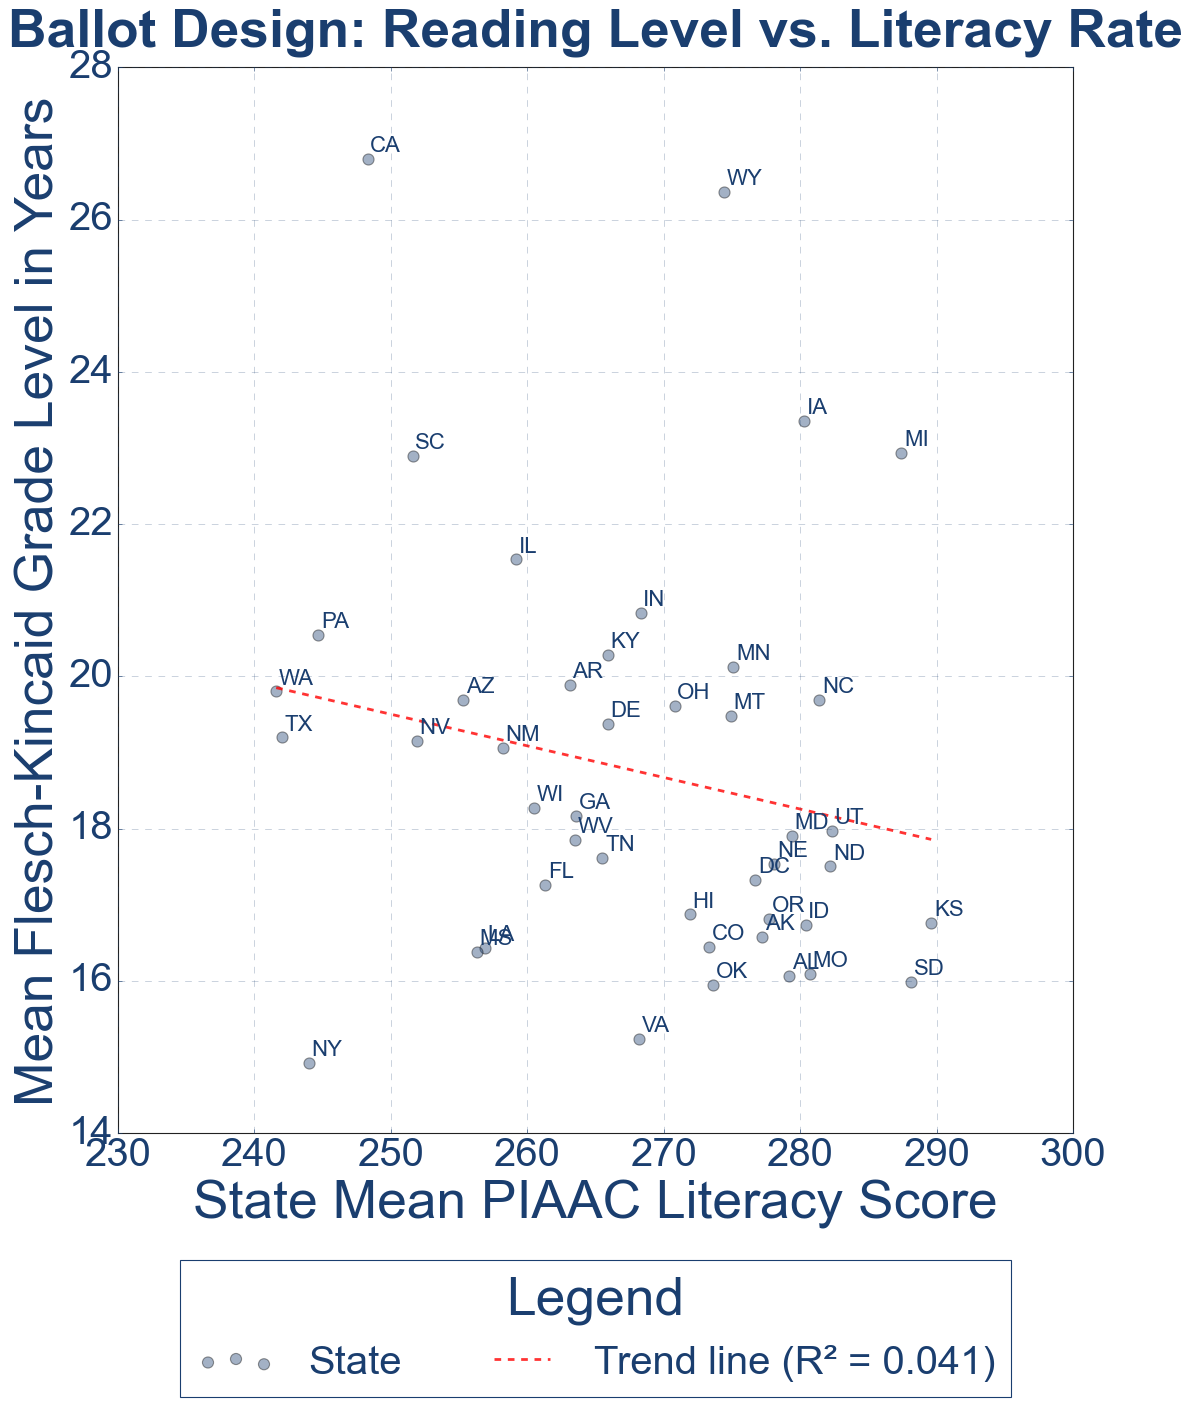

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 437/437 [00:00<00:00, 5951.16it/s]


<module 'matplotlib.pyplot' from '/Users/ericbolton/Documents/showballot/env/lib/python3.12/site-packages/matplotlib/pyplot.py'>

<Figure size 1120x1600 with 0 Axes>

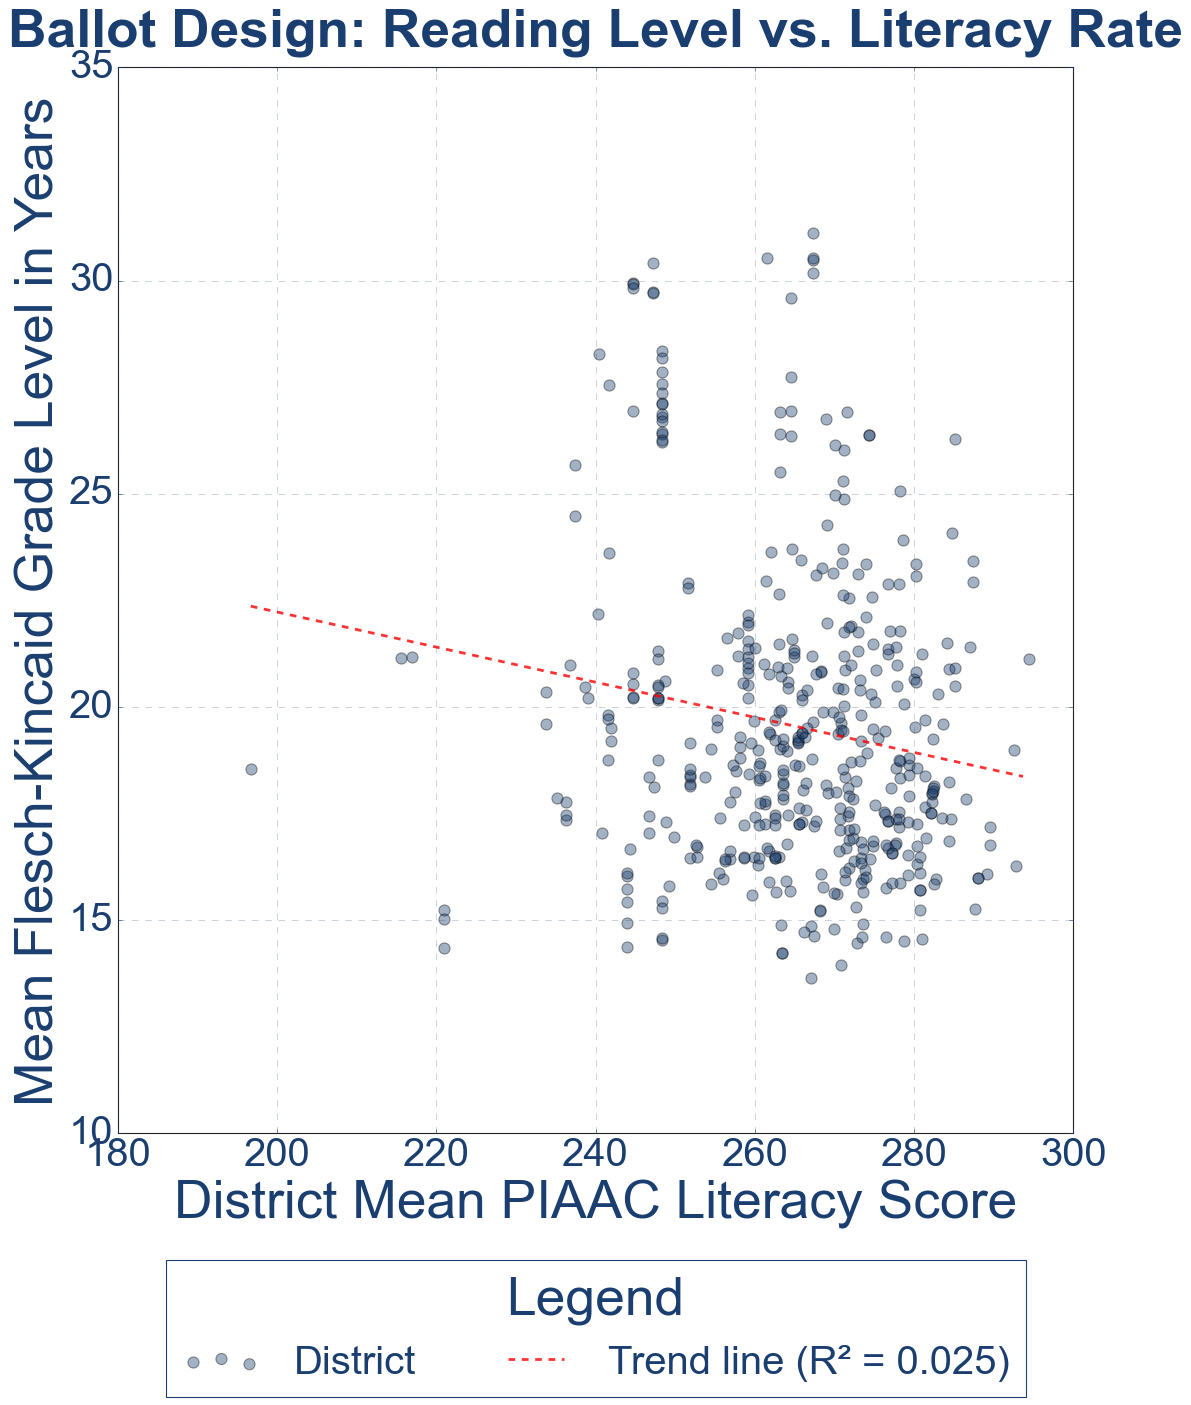

In [48]:
from jupyterthemes import jtplot
jtplot.style()
plot_df = get_plot_df('State')
plot_county_literacy(plot_df)
plt.show()

plot_df = get_plot_df('District')
plot_county_literacy(plot_df, type='District')
plt.show()

In [49]:
alert("plots generated")

# Get NYTimes Data

In [535]:
cdf = area_df.dropna(subset=['district']).copy()
cdf['district'] = cdf.state_id + '-CD' + area_df.district
x = cdf.groupby('district').county.nunique()
# cdf = cdf[cdf.district.isin(x[x == 1].index)]
county_lookup = dict(zip(cdf.district, cdf.county))

In [536]:
import requests
from bs4 import BeautifulSoup
from dataclasses import dataclass, asdict
from typing import List, Optional
import re

@dataclass
class ElectionResult:
    """Data class to store election results for a single county"""
    county: str
    margin: str
    margin_value: float
    winner: str
    total_votes: int
    percent_reporting: str
        
class MarginParser:
    """Handles parsing of margin strings into structured data"""
    
    @staticmethod
    def parse_margin(margin_text: str) -> tuple[float, str]:
        """
        Parse margin text into numeric value and winner
        Example: "Harris +29" -> (29.0, "Harris")
        """
        match = re.match(r"([\w\s\.-]+)(\+|<)\s*?([\d.]+)", margin_text)
        if match:
            winner, _, margin = match.groups()
            return float(margin), winner.strip()
        elif margin_text == "Tied":
            return 0.0, None
        elif margin_text == "—":
            return None, None
            
        raise ValueError(f"Unable to parse margin text: {margin_text}")

class VoteParser:
    """Handles parsing of vote counts and percentages"""
    
    @staticmethod
    def parse_votes(votes_text: str) -> int:
        """Convert vote text to integer, removing commas"""
        return int(votes_text.replace(',', ''))

    @staticmethod
    def parse_percent(percent_text: str) -> str:
        """Standardize percentage reporting format"""
        return percent_text.strip()

class TableParser:
    """Handles parsing of HTML table rows into ElectionResult objects"""
    
    def __init__(self, margin_parser: MarginParser, vote_parser: VoteParser):
        self.margin_parser = margin_parser
        self.vote_parser = vote_parser

    def parse_row(self, row) -> Optional[ElectionResult]:
        """Parse a single table row into an ElectionResult object"""
        try:
            cells = row.find_all(['th', 'td'])
            if len(cells) < 3:
                return None
            elif len(cells) == 3:
                county = cells[0].text.strip()
                margin_text = cells[1].text.strip()
                votes_text = cells[2].text.strip()
                percent_text = '100%'
            else:
                county = cells[0].text.strip()
                margin_text = cells[1].text.strip()
                votes_text = cells[2].text.strip()
                percent_text = cells[3].text.strip()
            
            margin_value, winner = self.margin_parser.parse_margin(margin_text)
            votes = self.vote_parser.parse_votes(votes_text)
            
            return ElectionResult(
                county=county,
                margin=margin_text,
                margin_value=margin_value,
                winner=winner,
                total_votes=votes,
                percent_reporting=self.vote_parser.parse_percent(percent_text)
            )
        except (ValueError, AttributeError) as e:
            print(f"Error parsing row: {e}")
            raise

class ElectionScraper:
    """Main class for scraping election results from a webpage"""
    
    def __init__(self, table_parser: TableParser):
        self.table_parser = table_parser
        
    def fetch_page(self, url: str) -> str:
        """Fetch webpage content"""
        response = requests.get(url)
        response.raise_for_status()
        time.sleep(1)
        return response.text
    
    def parse_alaska(self, html: str) -> List[ElectionResult]:
        soup = BeautifulSoup(html, 'html.parser')
        table = soup.find('table', {'data-rid': lambda x: x and 'AK-G' in x})
        pct_span = soup.find('span', {'class': 'est-pct'})
                
        if pct_span:
            match = re.search(r'(\d+)%', pct_span.get_text(strip=True))
            percent_reporting = float(match.group(1))
        else:
            percent_reporting = 100
                
        if not table:
            raise ValueError("Could not find results table")
            
        results = []
        winner = 'Trump'
        margin = 0
        votes = 0
        for row in table.find_all('tr')[1:]:  # Skip header row
            cells = row.find_all(['th', 'td'])
            if len(cells) < 3:
                continue
            if 'trump' in cells[0].text.lower():
                margin += float(cells[3].text.split('%')[-2].split(' ')[-1])
            elif 'harris' in cells[0].text.lower():
                margin -= float(cells[3].text.split('%')[-2].split(' ')[-1])
            if cells[2].text:
                votes += int(cells[2].text.replace(',', '').strip())
                
        results.append(ElectionResult(
            county='Alaska',
            margin=f'{winner.capitalize()} +{int(margin)}',
            margin_value=str(int(margin)),
            winner=winner,
            total_votes=votes,
            percent_reporting=f'{percent_reporting}%'
        ))
                
        return results

    def parse_standard_table(self, html: str) -> List[ElectionResult]:
        """Parse election results from a standard formatted table with candidate rows"""
        soup = BeautifulSoup(html, 'html.parser')
        table = soup.find('table', {'data-rid': lambda x: x and x[2:].startswith('-G')})
        
        if not table:
            raise ValueError("Could not find results table")
            
        pct_span = soup.find('span', {'class': 'est-pct'})
                
        if pct_span:
            match = re.search(r'(\d+)%', pct_span.get_text(strip=True))
            percent_reporting = float(match.group(1))
        else:
            percent_reporting = 100

        results = []
        winner = None
        margin = 0
        total_votes = 0

        second_place_candidates = []
        for row in table.find_all('tr'):
            cells = row.find_all(['th', 'td'])
            if len(cells) < 4:
                continue

            if 'Total reported' in cells[0].text:
                total_votes = int(cells[1].text.replace(',', ''))
                continue

            party_cell = cells[1].text.strip().lower()
            if not any(p in party_cell for p in ['dem', 'rep', 'ind']):
                continue

            votes = int(cells[2].text.replace(',', ''))
            pct = float(cells[3].text.split('+')[1].split('%')[0])

            candidate_cell = cells[0].text.strip().lower()
            if '*' in candidate_cell:  # Incumbent/winner
                winner = cells[0].find('span', class_='full-name').text.strip()
                margin += pct
            else:
                second_place_candidates += [pct]
        try:
            margin -= max(second_place_candidates)
        except:
            print(f'{table.text=}')
            for row in table.find_all('tr'):
                cells = row.find_all(['th', 'td'])
                print(f'{[c.text for c in cells]=}')
                print(f'{row.text=}')
                
            print(f'{second_place_candidates=}')
            input()
        
        results.append(ElectionResult(
            county=None,
            margin=f'{winner} +{margin:.1f}',
            margin_value=margin,
            winner=winner,
            total_votes=total_votes,
            percent_reporting=percent_reporting
        ))
        
        return results
    
    def parse_table(self, html: str) -> List[ElectionResult]:
        """Parse the election results table from HTML"""
        soup = BeautifulSoup(html, 'html.parser')
        table = soup.find('table', class_='medium')
        if not table:
            raise ValueError("Could not find results table")
            
        results = []
        for row in table.find_all('tr')[1:]:  # Skip header row
            result = self.table_parser.parse_row(row)
            if result:
                results.append(result)
                
        return results

    def get_results(self, url: str) -> List[ElectionResult]:
        """Main method to fetch and parse election results"""
        html = self.fetch_page(url)
        if 'alaska' in url:
            return self.parse_alaska(html)
        
        soup = BeautifulSoup(html, 'html.parser')
        if 'Uncontested' in soup.text:
            return []
        table = soup.find('table', class_='medium')
        if not table:
            pass
        elif 'Town' not in table.text:
            pass
        elif 'Town' in table.text and 'County' not in table.text:
            print('Towns but no county', url)
        elif table.text.index('Town') < table.text.index('County'):
            print('Town appears before county', url)
        else:
            print("Town appears after county: doesn't matter!", url)
            
        try:
            return self.parse_table(html)
        except ValueError as e:
            if str(e) == "Could not find results table":
                return self.parse_standard_table(html)
            raise

def create_scraper() -> ElectionScraper:
    """Factory function to create a configured ElectionScraper instance"""
    margin_parser = MarginParser()
    vote_parser = VoteParser()
    table_parser = TableParser(margin_parser, vote_parser)
    return ElectionScraper(table_parser)

In [485]:
# Example usage
@lru_cache(maxsize=10_000)
def main(url: str):
    scraper = create_scraper()
    try:
        results = scraper.get_results(url)
        return pd.DataFrame([asdict(r) for r in results])
    except Exception as e:
        print(url)
        print(f"Error scraping results: {e}")
        raise e

In [537]:
scraper = create_scraper()

In [538]:
state_lookups = {}
ct_df = pd.read_csv('data/raw/ct-town-to-planning-region.csv')
state_lookups['Connecticut'] = dict(zip(ct_df.town_name.str.lower(), ct_df.ce_name_2022))

for state in ['Massachusetts', 'Vermont', 'Maine', 'New Hampshire', 'Rhode Island']:
    wdf = pd.read_csv(f'data/raw/List_of_municipalities_in_{state.replace(" ", "_")}_1.csv').rename(columns={
        'Name': 'Municipality'
    })
    state_lookups[state] = dict(zip(wdf.Municipality.str.lower().str.strip('†'), wdf.County.str.removesuffix(' (seat)')))
    
   

In [539]:
suffixes = [
    ('City', False),
    ('Island Plantation', False),
    ('Plantation', False),
    ('Location', True),
    ('Town', False),
    ('County Townships', False),
    ('Township', False),
    ('Nation Voting District', False),
    ('Lake Township', False),
]
for state in ['Connecticut', 'Massachusetts', 'Vermont', 'Maine', 'New Hampshire', 'Rhode Island']:
    # Main code using the function
    for town, county in state_lookups[state].copy().items():
        for suffix, remove_possessive in suffixes:
            add_suffix = not any(town.lower().endswith(s[0].lower()) for s in suffixes)
            if add_suffix:
                key = f"{town}'s {suffix}" if remove_possessive else f"{town} {suffix}"
            else:
                key = town.removesuffix(f"'s {suffix}" if remove_possessive else f" {suffix}")
                if remove_possessive:
                    key = key.strip("'")

            if key.lower() not in state_lookups[state]:
                state_lookups[state][key.lower()] = county

In [540]:
state_lookups['Maine']

{'municipality': 'County',
 'portland': 'Cumberland',
 'lewiston': 'Androscoggin',
 'bangor': 'Penobscot',
 'south portland': 'Cumberland',
 'auburn': 'Androscoggin',
 'biddeford': 'York',
 'scarborough': 'Cumberland',
 'sanford': 'York',
 'brunswick': 'Cumberland',
 'westbrook': 'Cumberland',
 'saco': 'York',
 'augusta': 'Kennebec',
 'windham': 'Cumberland',
 'gorham': 'Cumberland',
 'waterville': 'Kennebec',
 'york': 'York',
 'falmouth': 'Cumberland',
 'kennebunk': 'York',
 'wells': 'York',
 'orono': 'Penobscot',
 'standish': 'Cumberland',
 'kittery': 'York',
 'lisbon': 'Androscoggin',
 'brewer': 'Penobscot',
 'topsham': 'Sagadahoc',
 'cape elizabeth': 'Cumberland',
 'yarmouth': 'Cumberland',
 'old orchard beach': 'York',
 'presque isle': 'Aroostook',
 'bath': 'Sagadahoc',
 'freeport': 'Cumberland',
 'skowhegan': 'Somerset',
 'cumberland': 'Cumberland',
 'ellsworth': 'Hancock',
 'buxton': 'York',
 'gray': 'Cumberland',
 'berwick': 'York',
 'winslow': 'Kennebec',
 'waterboro': 'York',

In [541]:
import time 

def fix_df(df):
    main_winner = df.winner.iloc[0] if 'Trump' not in set(df.winner.unique()) else 'Trump'
    new_df = df.iloc[:1]
    df['margin_value'] = df.apply(
        lambda x: -x.margin_value if x.winner == main_winner else x.margin_value, axis=1)
    margin = (df.margin_value * df.total_votes).sum() / df.total_votes.sum()
    winner = main_winner if margin < 0 else list(set(df.winner.unique()) - {main_winner})[0]
    new_df['margin_value'] = float(f'{abs(margin):.1f}')
    new_df['margin'] = f'{winner} +{abs(margin):.1f}'
    new_df['total_votes'] = df.total_votes.sum()
    return new_df

# Replace with actual URL when using
dfs = []
for state in tqdm(area_df.state.unique()):
    state = state.replace('District of Columbia', 'Washington DC')
    url = f"https://www.nytimes.com/interactive/2024/11/05/us/elections/results-{state.lower().replace(' ', '-')}-president.html"
    try:
        df = main(url)
    except Exception as e:
        print(e)
        break
    if state == 'Washington DC':
        new_df = df.iloc[:1]
        new_df['county'] = 'District of Columbia'
        new_df['state'] = 'District of Columbia'
        margin = (df.margin_value * df.total_votes).sum() / df.total_votes.sum()
        new_df['margin_value'] = float(round(margin))
        new_df['margin'] = f'Harris +{round(margin)}'
        new_df['total_votes'] = df.total_votes.sum()
        dfs.append(new_df)
    elif state in [
        'Connecticut', 'Massachusetts', 'Vermont', 'Maine', 'New Hampshire', 'Rhode Island'
    ]:
        df = df.copy()
        df['county'] = df.county.str.lower().map(state_lookups[state])
        new_df = df.groupby('county').apply(lambda df: fix_df(df)).drop(columns='county').reset_index().drop(columns='level_1')
        new_df['state'] = state
        dfs.append(new_df)
    else:
        df['state'] = state
        dfs.append(df)

president_turnout_df = pd.concat(dfs)

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 1011.02it/s]


In [542]:
dfs = []
for state, state_id, district in tqdm(area_df[['state', 'state_id', 'district']].value_counts().index):
    d = int(district[:2]) or 'at-large'
    url = f"https://www.nytimes.com/interactive/2024/11/05/us/elections/results-{state.lower().replace(' ', '-')}-us-house-{d}.html"
    try:
        df = main(url)
#     except AttributeError:
#         print('Uncontested:', state, district)
    except Exception as e:
        print(e)
        continue
    if len(df) == 0:
        continue
    district = f'{state_id}-CD{district[:2]}'
    df['district'] = district
    df.loc[df.county.isna(), 'county'] = df.loc[df.county.isna(), 'district'].map(county_lookup)
    if state in [
        'Connecticut', 'Massachusetts', 'Vermont', 'Maine', 'New Hampshire', 'Rhode Island'
    ]:
        df = df.copy()
        counties = df.county.str.lower().map(state_lookups[state])
        if counties.isna().any():
            for county in df.county:
                if county.lower() not in state_lookups[state] and county != 'District':
                    for town in state_lookups[state]:
                        if county.lower() in town.lower() or town.lower() in county.lower():
                            print(f'{town=}', f'{county=}')
        df['county'] = counties
        if df.county.isna().all():
            df['county'] = district
        new_df = df.groupby('county').apply(lambda df: fix_df(df)).drop(columns='county').reset_index().drop(columns='level_1')
        new_df['state'] = state
        dfs.append(new_df)
    else:
        df['state'] = state
        dfs.append(df)

district_turnout_df = pd.concat(dfs)

 39%|████████████████████████████████████▊                                                         | 171/436 [00:00<00:00, 1709.52it/s]

town='wentworth' county='Wentworth’s Location'


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 436/436 [00:00<00:00, 1279.20it/s]

https://www.nytimes.com/interactive/2024/11/05/us/elections/results-district-of-columbia-us-house-98.html
Error scraping results: 404 Client Error: Not Found for url: https://www.nytimes.com/interactive/2024/11/05/us/elections/results-district-of-columbia-us-house-98.html
404 Client Error: Not Found for url: https://www.nytimes.com/interactive/2024/11/05/us/elections/results-district-of-columbia-us-house-98.html


In [543]:
dfs = []
for state, state_id in tqdm(area_df[['state', 'state_id']].value_counts().index):
    url = f"https://www.nytimes.com/interactive/2024/11/05/us/elections/results-{state.lower().replace(' ', '-')}-us-senate.html"
    if state == 'Nebraska':
        url = f"https://www.nytimes.com/interactive/2024/11/05/us/elections/results-{state.lower().replace(' ', '-')}-us-senate-special.html"
    try:
        df = main(url)
#     except AttributeError:
#         print('Uncontested:', state, district)
    except requests.HTTPError:
        print(state)
        continue
    except Exception as e:
        print(e)
        raise e
    if len(df) == 0:
        continue
    if state in [
        'Connecticut', 'Massachusetts', 'Vermont', 'Maine', 'New Hampshire', 'Rhode Island'
    ]:
        df = df.copy()
        counties = df.county.str.lower().map(state_lookups[state])
        if counties.isna().any():
            for county in df.county:
                if county.lower() not in state_lookups[state] and county != 'District':
                    for town in state_lookups[state]:
                        if county.lower() in town.lower() or town.lower() in county.lower():
                            print(f'{town=}', f'{county=}')
        df['county'] = counties
        if df.county.isna().all():
            df['county'] = state
        new_df = df.groupby('county').apply(lambda df: fix_df(df)).drop(columns='county').reset_index().drop(columns='level_1')
        new_df['state'] = state
        dfs.append(new_df)
    else:
        df['state'] = state
        dfs.append(df)

senate_turnout_df = pd.concat(dfs)

 10%|█████████▋                                                                                         | 5/51 [00:00<00:01, 34.37it/s]

https://www.nytimes.com/interactive/2024/11/05/us/elections/results-illinois-us-senate.html
Error scraping results: 404 Client Error: Not Found for url: https://www.nytimes.com/interactive/2024/11/05/us/elections/results-illinois-us-senate.html
Illinois
https://www.nytimes.com/interactive/2024/11/05/us/elections/results-georgia-us-senate.html
Error scraping results: 404 Client Error: Not Found for url: https://www.nytimes.com/interactive/2024/11/05/us/elections/results-georgia-us-senate.html
Georgia


 25%|████████████████████████▉                                                                         | 13/51 [00:00<00:01, 20.08it/s]

https://www.nytimes.com/interactive/2024/11/05/us/elections/results-iowa-us-senate.html
Error scraping results: 404 Client Error: Not Found for url: https://www.nytimes.com/interactive/2024/11/05/us/elections/results-iowa-us-senate.html
Iowa
https://www.nytimes.com/interactive/2024/11/05/us/elections/results-north-carolina-us-senate.html
Error scraping results: 404 Client Error: Not Found for url: https://www.nytimes.com/interactive/2024/11/05/us/elections/results-north-carolina-us-senate.html
North Carolina


 41%|████████████████████████████████████████▎                                                         | 21/51 [00:00<00:01, 23.20it/s]

https://www.nytimes.com/interactive/2024/11/05/us/elections/results-kentucky-us-senate.html
Error scraping results: 404 Client Error: Not Found for url: https://www.nytimes.com/interactive/2024/11/05/us/elections/results-kentucky-us-senate.html
Kentucky
https://www.nytimes.com/interactive/2024/11/05/us/elections/results-kansas-us-senate.html
Error scraping results: 404 Client Error: Not Found for url: https://www.nytimes.com/interactive/2024/11/05/us/elections/results-kansas-us-senate.html
Kansas
https://www.nytimes.com/interactive/2024/11/05/us/elections/results-alabama-us-senate.html
Error scraping results: 404 Client Error: Not Found for url: https://www.nytimes.com/interactive/2024/11/05/us/elections/results-alabama-us-senate.html
Alabama
https://www.nytimes.com/interactive/2024/11/05/us/elections/results-oklahoma-us-senate.html
Error scraping results: 404 Client Error: Not Found for url: https://www.nytimes.com/interactive/2024/11/05/us/elections/results-oklahoma-us-senate.html
Ok

 53%|███████████████████████████████████████████████████▉                                              | 27/51 [00:01<00:01, 15.19it/s]

https://www.nytimes.com/interactive/2024/11/05/us/elections/results-arkansas-us-senate.html
Error scraping results: 404 Client Error: Not Found for url: https://www.nytimes.com/interactive/2024/11/05/us/elections/results-arkansas-us-senate.html
Arkansas
https://www.nytimes.com/interactive/2024/11/05/us/elections/results-louisiana-us-senate.html
Error scraping results: 404 Client Error: Not Found for url: https://www.nytimes.com/interactive/2024/11/05/us/elections/results-louisiana-us-senate.html
Louisiana


 61%|███████████████████████████████████████████████████████████▌                                      | 31/51 [00:01<00:01, 14.61it/s]

https://www.nytimes.com/interactive/2024/11/05/us/elections/results-colorado-us-senate.html
Error scraping results: 404 Client Error: Not Found for url: https://www.nytimes.com/interactive/2024/11/05/us/elections/results-colorado-us-senate.html
Colorado
https://www.nytimes.com/interactive/2024/11/05/us/elections/results-south-carolina-us-senate.html
Error scraping results: 404 Client Error: Not Found for url: https://www.nytimes.com/interactive/2024/11/05/us/elections/results-south-carolina-us-senate.html
South Carolina


 69%|███████████████████████████████████████████████████████████████████▎                              | 35/51 [00:01<00:00, 18.24it/s]

https://www.nytimes.com/interactive/2024/11/05/us/elections/results-oregon-us-senate.html
Error scraping results: 404 Client Error: Not Found for url: https://www.nytimes.com/interactive/2024/11/05/us/elections/results-oregon-us-senate.html
Oregon


 78%|████████████████████████████████████████████████████████████████████████████▊                     | 40/51 [00:02<00:00, 15.04it/s]

https://www.nytimes.com/interactive/2024/11/05/us/elections/results-south-dakota-us-senate.html
Error scraping results: 404 Client Error: Not Found for url: https://www.nytimes.com/interactive/2024/11/05/us/elections/results-south-dakota-us-senate.html
South Dakota
https://www.nytimes.com/interactive/2024/11/05/us/elections/results-new-hampshire-us-senate.html
Error scraping results: 404 Client Error: Not Found for url: https://www.nytimes.com/interactive/2024/11/05/us/elections/results-new-hampshire-us-senate.html
New Hampshire


 92%|██████████████████████████████████████████████████████████████████████████████████████████▎       | 47/51 [00:02<00:00, 19.06it/s]

https://www.nytimes.com/interactive/2024/11/05/us/elections/results-idaho-us-senate.html
Error scraping results: 404 Client Error: Not Found for url: https://www.nytimes.com/interactive/2024/11/05/us/elections/results-idaho-us-senate.html
Idaho
https://www.nytimes.com/interactive/2024/11/05/us/elections/results-alaska-us-senate.html
Error scraping results: 404 Client Error: Not Found for url: https://www.nytimes.com/interactive/2024/11/05/us/elections/results-alaska-us-senate.html
Alaska


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [00:02<00:00, 18.46it/s]

https://www.nytimes.com/interactive/2024/11/05/us/elections/results-district-of-columbia-us-senate.html
Error scraping results: 404 Client Error: Not Found for url: https://www.nytimes.com/interactive/2024/11/05/us/elections/results-district-of-columbia-us-senate.html
District of Columbia


In [544]:
alert('Turnout DF created')

In [558]:
county_pop_df = pd.read_csv('data/raw/CVAP_2018-2022_ACS_csv_files/County.csv', encoding='latin1')
county_pop_df['key'] = county_pop_df.geoname.str.split(', ')\
    .apply(lambda x: x[0] if x[1] != 'Alaska' else x[1])\
    .str.removesuffix(' County')\
    .str.removesuffix(' Parish')\
    .str.removesuffix(' Municipality')\
    .str.removesuffix(' Municipio')\
    .str.removesuffix(' Borough')\
    .str.removesuffix(' and')\
    .str.removesuffix(' (East|West)')\
    .str.removesuffix(' Census Area')\
    .apply(lambda x: x + ' City' if (x == 'James' or x == 'St. Louis') else x)
county_pop_df = county_pop_df[county_pop_df.lntitle == 'Total']
county_pop_df['state'] = county_pop_df.geoname.str.split(', ').apply(lambda x: x[1])
county_pop_lookup = dict(zip(county_pop_df[['state', 'key']].apply(tuple, axis=1), 
                             county_pop_df.tot_est))
county_pop_lookup['Alaska', 'Alaska'] = county_pop_df[county_pop_df.state == 'Alaska'].tot_est.sum()

In [559]:
total_votes_lookup = dict(district_turnout_df.groupby(['county', 'state']).total_votes.sum())
district_turnout_df['total_votes'] = district_turnout_df[['county', 'state']].apply(tuple, axis=1).map(total_votes_lookup)

In [560]:
for turnout_df in [president_turnout_df, district_turnout_df, senate_turnout_df]:
    turnout_df['voting_pop'] = turnout_df[['state', 'county']].apply(tuple, axis=1).map(county_pop_lookup)
    set(county_pop_df.state.unique()) - set(turnout_df[turnout_df.voting_pop.notna()].state.unique())

    turnout_df['turnout'] = (
        (turnout_df.total_votes / turnout_df.voting_pop) / 
        (turnout_df.percent_reporting.str.replace('>95', '100').str.strip('%').astype(float) / 100)
    )
    turnout_df.dropna().sort_values(by='turnout').head(10)
    turnout_df.dropna().sort_values(by='turnout', ascending=False).head(10)

{'Puerto Rico'}

,county,margin,margin_value,winner,total_votes,percent_reporting,state,voting_pop,turnout
6,St. Louis City,Harris +65,65.0,Harris,116082,>95%,Missouri,999705.0,0.116116
151,Chattahoochee,Trump +16,16.0,Trump,1694,>95%,Georgia,9400.0,0.180213
39,Seward,Trump +40,40.0,Trump,4402,>95%,Kansas,21940.0,0.200638
213,Dallam,Trump +78,78.0,Trump,1442,>95%,Texas,7165.0,0.201256
26,Oglala Lakota,Harris +71,71.0,Harris,3062,>95%,South Dakota,13695.0,0.223585
36,Todd,Harris +50,50.0,Harris,2126,>95%,South Dakota,9355.0,0.227258
161,Deaf Smith,Trump +52,52.0,Trump,4275,>95%,Texas,18585.0,0.230024
30,Washington,Harris +30,30.0,Harris,10424,>95%,Mississippi,44605.0,0.233696
27,Ford,Trump +39,39.0,Trump,7998,>95%,Kansas,34210.0,0.233791
25,Geary,Trump +18,18.0,Trump,8821,>95%,Kansas,36245.0,0.243371


,county,margin,margin_value,winner,total_votes,percent_reporting,state,voting_pop,turnout
251,Kenedy,Trump +47,47.0,Trump,158,>95%,Texas,115.0,1.373913
253,Loving,Trump +78,78.0,Trump,97,>95%,Texas,95.0,1.021053
61,Mineral,Trump +13,13.0,Trump,753,>95%,Colorado,795.0,0.947170
28,Daggett,Trump +62,62.0,Trump,550,>95%,Utah,640.0,0.859375
63,San Juan,Harris +32,32.0,Harris,588,>95%,Colorado,690.0,0.852174
43,Ouray,Harris +21,21.0,Harris,4098,>95%,Colorado,4935.0,0.830395
50,Garfield,Trump +90,90.0,Trump,800,>95%,Montana,975.0,0.820513
29,Sumter,Trump +38,38.0,Trump,105217,100%,Florida,131830.0,0.798126
45,Custer,Trump +36,36.0,Trump,3867,>95%,Colorado,4885.0,0.791607
55,Petroleum,Trump +76,76.0,Trump,324,>95%,Montana,415.0,0.780723


{'District of Columbia', 'Puerto Rico'}

,county,margin,margin_value,winner,total_votes,percent_reporting,district,state,voting_pop,turnout
7,Talladega,Palmer +75,75.0,Palmer,1053,>95%,AL-CD06,Alabama,81105.0,0.012983
8,El Paso,Boebert +59,59.0,Boebert,10792,>95%,CO-CD04,Colorado,730325.0,0.014777
9,El Paso,Pettersen +11,11.0,Pettersen,10792,>95%,CO-CD07,Colorado,730325.0,0.014777
2,Middlesex,McGovern +43.3,43.3,McGovern,27366,>95%,MA-CD02,Massachusetts,1623110.0,0.016860
2,Philadelphia,Scanlon +48,48.0,Scanlon,29220,>95%,PA-CD05,Pennsylvania,1593210.0,0.018340
4,Jefferson,Guthrie +27,27.0,Guthrie,21042,>95%,KY-CD02,Kentucky,779230.0,0.027004
20,Oktibbeha,Kelly +56,56.0,Kelly,1218,85%,MS-CD01,Mississippi,51390.0,0.027884
11,Tazewell,McGraw +40,40.0,McGraw,5275,>95%,IL-CD17,Illinois,131275.0,0.040183
9,Bowie,Fallon +69,69.0,Fallon,4401,>95%,TX-CD04,Texas,92745.0,0.047453
29,Callahan,Arrington +84,84.0,Arrington,746,>95%,TX-CD19,Texas,13870.0,0.053785


,county,margin,margin_value,winner,total_votes,percent_reporting,district,state,voting_pop,turnout
3,Teller,Matveyuk +36,36.0,Matveyuk,755288,>95%,CO-CD07,Colorado,24760.0,30.504362
5,Gila,Crane +32,32.0,Crane,922164,>95%,AZ-CD02,Arizona,53420.0,17.262523
2,Ozaukee,Grothman +18,18.0,Grothman,790514,>95%,WI-CD06,Wisconsin,91745.0,8.616426
2,Sutter,LaMalfa +36,36.0,LaMalfa,629542,>95%,CA-CD01,California,99100.0,6.352593
1,Orange,Gunderson +11,11.0,Gunderson,15386640,>95%,CA-CD49,California,3175225.0,4.845842
0,Orange,Steel +1.3,1.3,Steel,15386640,>95%,CA-CD45,California,3175225.0,4.845842
0,Orange,Kim +10,10.0,Kim,15386640,>95%,CA-CD40,California,3175225.0,4.845842
1,Orange,Sanchez +8,8.0,Sanchez,15386640,>95%,CA-CD38,California,3175225.0,4.845842
0,Licking,Balderson +35,35.0,Balderson,850666,>95%,OH-CD12,Ohio,178845.0,4.756443
2,DuPage,Krishnamoorthi +7,7.0,Krishnamoorthi,4309692,>95%,IL-CD08,Illinois,930560.0,4.631289


{'Alabama',
 'Alaska',
 'Arkansas',
 'Colorado',
 'District of Columbia',
 'Georgia',
 'Idaho',
 'Illinois',
 'Iowa',
 'Kansas',
 'Kentucky',
 'Louisiana',
 'New Hampshire',
 'North Carolina',
 'Oklahoma',
 'Oregon',
 'Puerto Rico',
 'South Carolina',
 'South Dakota'}

,county,margin,margin_value,winner,total_votes,percent_reporting,state,voting_pop,turnout
6,St. Louis City,Kunce +66,66.0,Kunce,115669,>95%,Missouri,999705.0,0.115703
213,Dallam,Cruz +75,75.0,Cruz,1420,>95%,Texas,7165.0,0.198186
87,Starr,Cruz +2,2.0,Cruz,14126,>95%,Texas,65715.0,0.214959
160,Deaf Smith,Cruz +50,50.0,Cruz,4214,>95%,Texas,18585.0,0.226742
30,Washington,Pinkins +27,27.0,Pinkins,10403,>95%,Mississippi,44605.0,0.233225
174,Reeves,Cruz +27,27.0,Cruz,3278,>95%,Texas,14020.0,0.233809
8,Bronx,Gillibrand +52,52.0,Gillibrand,321484,94%,New York,1443230.0,0.236971
31,Webb,Allred +9,9.0,Allred,63737,>95%,Texas,267280.0,0.238465
11,Hidalgo,Allred +7,7.0,Allred,211128,>95%,Texas,873165.0,0.241796
49,Sioux,Christiansen +41,41.0,Christiansen,946,>95%,North Dakota,3895.0,0.242875


,county,margin,margin_value,winner,total_votes,percent_reporting,state,voting_pop,turnout
251,Kenedy,Cruz +31,31.0,Cruz,144,>95%,Texas,115.0,1.252174
253,Loving,Cruz +61,61.0,Cruz,95,>95%,Texas,95.0,1.000000
28,Daggett,Curtis +69,69.0,Curtis,542,>95%,Utah,640.0,0.846875
50,Garfield,Sheehy +82,82.0,Sheehy,796,>95%,Montana,975.0,0.816410
29,Sumter,Scott +39,39.0,Scott,104582,100%,Florida,131830.0,0.793310
55,Petroleum,Sheehy +68,68.0,Sheehy,328,>95%,Montana,415.0,0.790361
45,Goochland,Cao +19,19.0,Cao,19349,>95%,Virginia,24905.0,0.776912
51,Billings,Cramer +64,64.0,Cramer,646,>95%,North Dakota,840.0,0.769048
82,Keweenaw,Rogers +14,14.0,Rogers,1584,>95%,Michigan,2090.0,0.757895
90,Blaine,Ricketts +80,80.0,Ricketts,290,>95%,Nebraska,385.0,0.753247


In [562]:
geometry_lookup = dict(zip(
    all_df[['County', 'district', 'zip']].apply(lambda row: tuple(row), axis=1),
    all_df.geometry
))
president_turnout_lookup = dict(zip(president_turnout_df[['county', 'state']].apply(tuple, axis=1), president_turnout_df.turnout))
senate_turnout_lookup = dict(zip(senate_turnout_df[['county', 'state']].apply(tuple, axis=1), senate_turnout_df.turnout))
district_turnout_lookup = dict(zip(district_turnout_df[['county', 'state']].apply(tuple, axis=1), district_turnout_df.turnout))
voting_pop_lookup = dict(zip(president_turnout_df[['county', 'state']].apply(tuple, axis=1), president_turnout_df.voting_pop))

all_df['geometry'] = all_df[['County', 'district', 'zip']].apply(lambda row: geometry_lookup[tuple(row)], axis=1)
all_df['president_turnout'] = all_df[['County', 'State']].apply(lambda x: tuple(x) if x.State != 'Alaska' else ('Alaska', 'Alaska'), axis=1).map(president_turnout_lookup)
all_df['house_turnout'] = all_df[['County', 'State']].apply(lambda x: tuple(x) if x.State != 'Alaska' else ('Alaska', 'Alaska'), axis=1).map(district_turnout_lookup)
all_df['senate_turnout'] = all_df[['County', 'State']].apply(lambda x: tuple(x) if x.State != 'Alaska' else ('Alaska', 'Alaska'), axis=1).map(senate_turnout_lookup)
all_df['voting_pop'] = all_df[['County', 'State']].apply(lambda x: tuple(x) if x.State != 'Alaska' else ('Alaska', 'Alaska'), axis=1).map(voting_pop_lookup)

all_df['score'] = (
    all_df.grade_level.astype(float) * all_df.unique_decisions.astype(float)
)/ all_df.literacy_score_all

map_df = (
    gpd.GeoDataFrame(all_df, crs=area_df.crs)
    .dropna(subset=['geometry'])
    .drop_duplicates(['County', 'district', 'zip'])
    .rename(columns={'complexity_score': 'complexity'})
)

state_id_lookup = dict(zip(area_df.state, area_df.state_id))
map_df['state_id'] = map_df.State.map(state_id_lookup)
map_df['races'] = map_df['races'].apply(len)
map_df['comp_races'] = map_df['comp_races'].apply(len)
map_df['measures'] = map_df['measures'].apply(len)

In [563]:
from matplotlib.patches import Patch
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import to_rgb

def reposition_state(gdf, state_name, scale_factor=None, shift_x=0, shift_y=0):
    """
    Reposition a single state's geometry with optional scaling
    """
    state_mask = gdf.State == state_name
    if not state_mask.any():
        return gdf
    
    gdf = gdf.copy()
    state_geom = gdf[state_mask]
    
    if scale_factor:
        centroid = state_geom.geometry.centroid.iloc[0]
        scaled_geom = state_geom.geometry.scale(
            xfact=scale_factor,
            yfact=scale_factor,
            origin=centroid
        )
        gdf.loc[state_mask, 'geometry'] = scaled_geom
    
    # Apply translation after scaling
    gdf.loc[state_mask, 'geometry'] = gdf.loc[state_mask, 'geometry'].translate(xoff=shift_x, yoff=shift_y)
    return gdf

def reposition_states(gdf):
    """
    Reposition Alaska and Hawaii for continental US view
    """
    # More dramatic repositioning
    gdf = reposition_state(gdf, 'Alaska', scale_factor=0.35, shift_x=-2000000, shift_y=-2000000)
    gdf = reposition_state(gdf, 'Hawaii', shift_x=-1000000, shift_y=-1000000)
    return gdf

def create_color_scale(values, color):
    """
    Create a color scale for a single variable, handling NaN values
    """
    # Convert single color to RGB for manipulation
    base_color = to_rgb(color)
    
    # Create 5 shades of the color from light to dark
    n_classes = 5
    alphas = np.linspace(0.0, 1.0, n_classes)
    
    colors = []
    for alpha in alphas:
        rgb = tuple(c * alpha + (1 - alpha) for c in base_color)
        colors.append(rgb)
    
    # Handle NaN values by creating quantile breaks only for non-NaN values
    non_nan_values = values[~pd.isna(values)]
    breaks = pd.qcut(non_nan_values, q=n_classes, labels=False, duplicates='drop')
    
    # Create a mapping for all values including NaNs
    color_mapping = pd.Series(index=values.index, dtype='object')
    color_mapping[~pd.isna(values)] = breaks.map(dict(enumerate(colors)))
    color_mapping[pd.isna(values)] = (1, 1, 1)  # White for NaN values
    
    return colors, color_mapping

def style_map(ax, title):
    """
    Apply consistent styling to map
    """
    ax.axis('off')
    ax.set_title(title, fontsize=16, pad=20)
    
    # Set background color to white
    ax.set_facecolor('white')
    plt.gcf().patch.set_facecolor('white')
    
    # Add source note
    plt.figtext(0.99, 0.01,
                'Source: Election Data Analysis',
                ha='right',
                fontsize=8,
                style='italic')

def create_legend(ax, colors, label, position=(0.5, -0.1)):
    """
    Create a legend for the map
    """
    legend_elements = [
        Patch(facecolor=color, linewidth=0)
        for color in colors
    ]
    
    labels = ['Very Low', 'Low', 'Medium', 'High', 'Very High']
    
    # Add NaN to legend
    legend_elements.append(Patch(facecolor='white', linewidth=0.5, edgecolor='gray'))
    labels.append('No Data')
    
    ax.legend(legend_elements,
             labels,
             title=label,
             bbox_to_anchor=position,
             loc='upper center',
             ncol=6)

def create_choropleth(gdf, column, color, title):
    """
    Create a choropleth map for a single variable
    """
    # Prepare the map
    gdf = reposition_states(gdf)
    gdf = gdf.to_crs(epsg=3857)
    
    # Create color scheme
    colors, color_mapping = create_color_scale(gdf[column], color)
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(15, 10))
    
    # Plot the map with very thin boundaries
    gdf.plot(color=color_mapping,
             ax=ax,
             edgecolor=None,
             linewidth=0.0,
             alpha=0.9)  # Slight transparency to help see patterns
    
    # Style the map
    style_map(ax, title)
    
    # Add legend
    create_legend(ax, colors, column)
    
    # Adjust layout
    plt.tight_layout()
    
    return fig, ax

def plot_maps(gdf):
    """
    Create separate maps for score and turnout
    """
    # Create score map
    fig1, ax1 = create_choropleth(
        gdf,
        'score',
        'red',
        'Electoral District Scores'
    )
    
    # Create turnout map
    fig2, ax2 = create_choropleth(
        gdf,
        'turnout',
        'blue',
        'Voter Turnout Rates'
    )
    
    return fig1, fig2

In [ ]:
plot_maps(map_df.dropna().sample(1000))

(<Figure size 1200x800 with 1 Axes>, <Figure size 1200x800 with 1 Axes>)

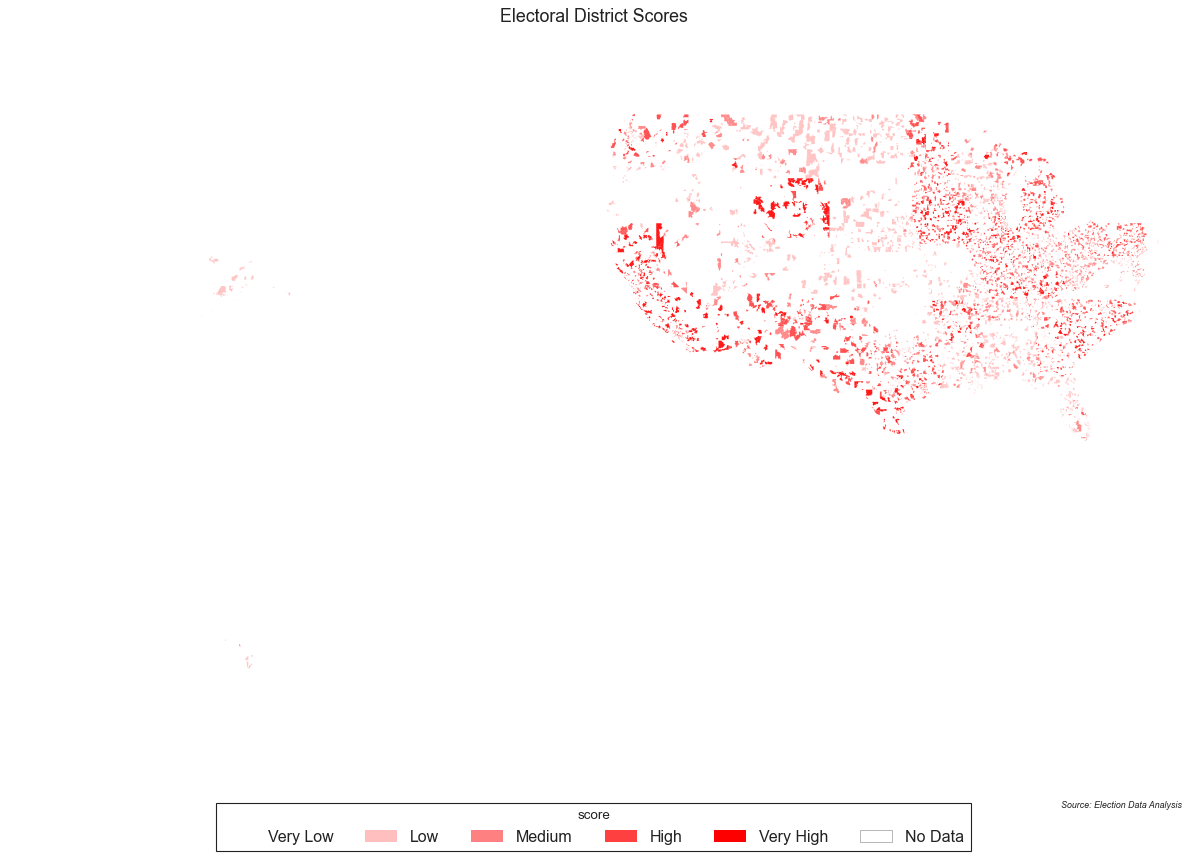

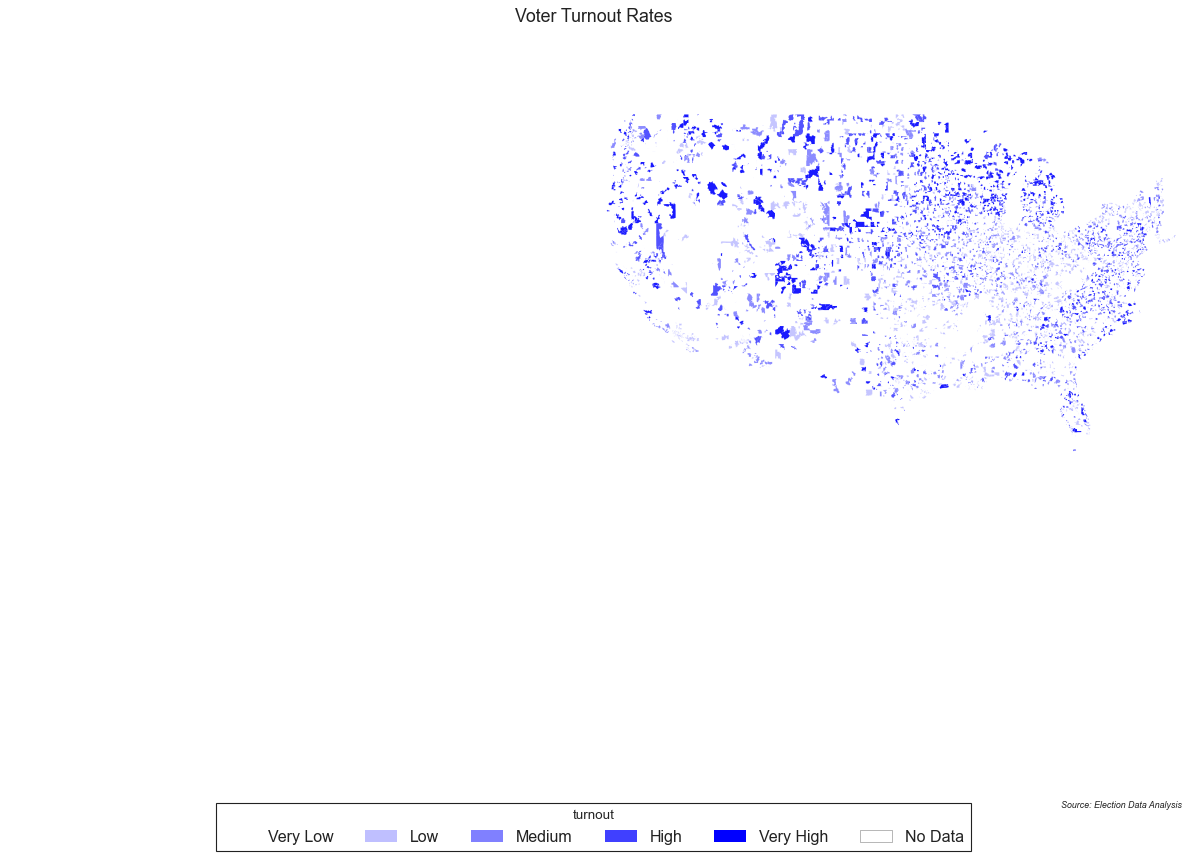

In [99]:
plot_maps(map_df.dropna().sample(10000))

(<Figure size 1200x800 with 1 Axes>, <Figure size 1200x800 with 1 Axes>)

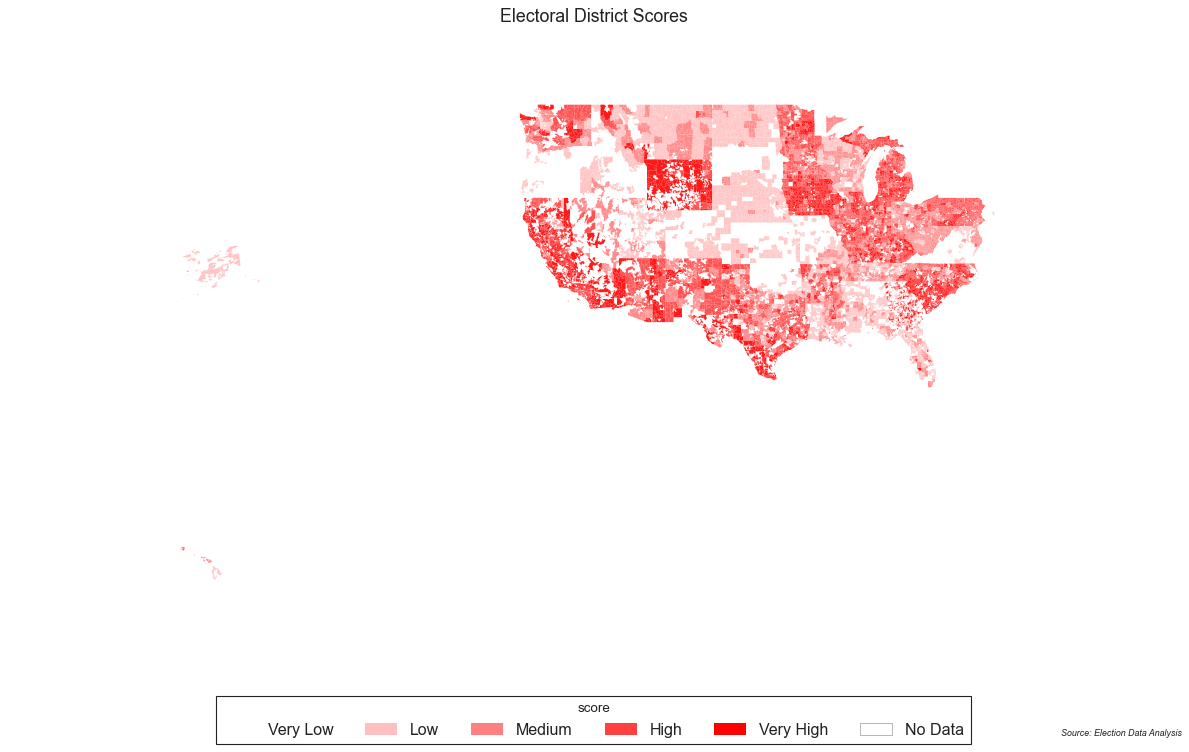

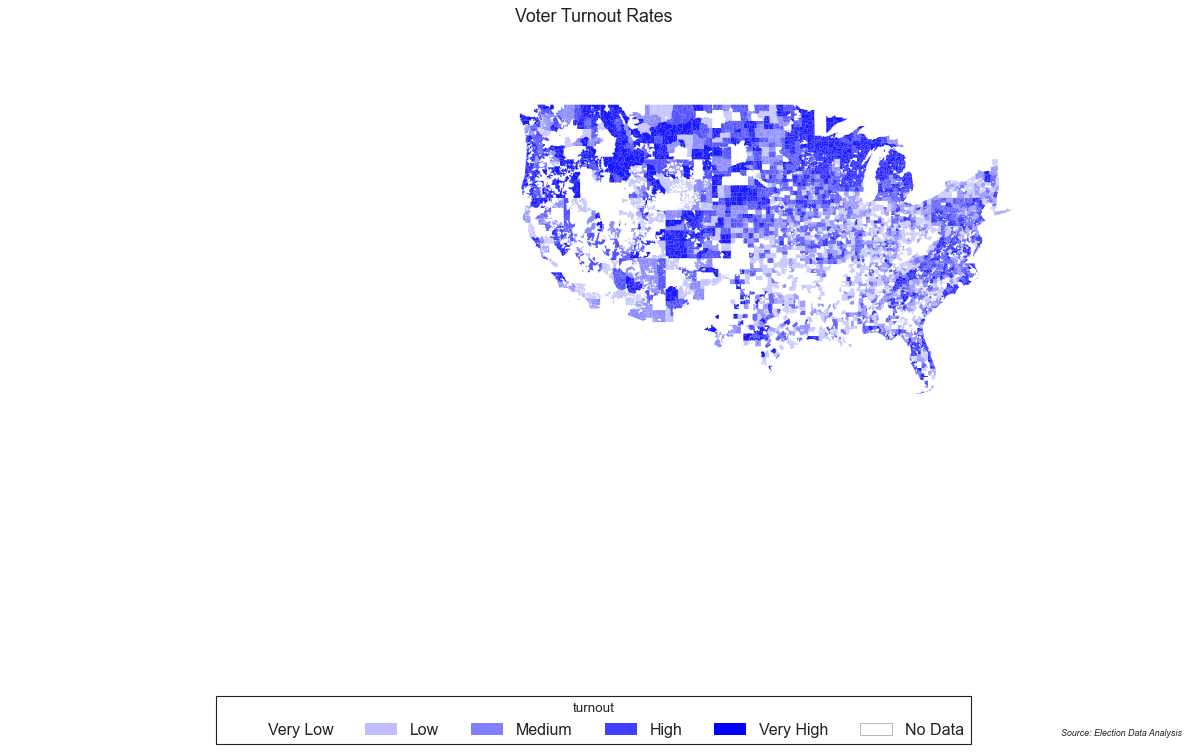

In [100]:
plot_maps(map_df.dropna())

0        129165.0
1        129165.0
2        129165.0
5        119994.0
6        119994.0
           ...   
56999      2413.0
57004       473.0
57015     13870.0
57019      3690.0
57034      1675.0
Name: zip, Length: 47728, dtype: float64

In [565]:
map_df['population'] = map_df.zip.astype(int).apply(str).map(population_lookup)
map_df = map_df.rename(columns={
    'population': 'zip_population',
    'voting_pop': 'county_voting_age_population',
    'president_turnout': 'county_president_turnout',
    'house_turnout': 'county_house_turnout',
    'senate_turnout': 'county_senate_turnout'
}).drop_duplicates(['zip'])

In [566]:
map_df.to_file('data/archive/turnout_20241121.shp', index=False)

In [567]:
pd.DataFrame(map_df).drop(columns='geometry').to_csv('data/archive/turnout_20241121.csv', index=False)

True

In [502]:
alert()

In [454]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.font_manager import FontProperties

def create_trend_plot(gdf, x_col='score', y_col='turnout', level='County'):
    """
    Create a scatter plot with trend line showing relationship between two variables
    """
    # Data preparation
    df = gdf.copy()
    
    # Convert columns to numeric, handling any non-numeric values
    df[x_col] = pd.to_numeric(df[x_col], errors='coerce')
    df[y_col] = pd.to_numeric(df[y_col], errors='coerce')
    
    # Remove any rows with NaN values
    df = df.dropna(subset=[x_col, y_col])
    
    # Create figure with white background
    fig, ax = plt.subplots(figsize=(14, 20), facecolor='white')
    ax.set_facecolor('white')
    
    # Set font
    plt.rcParams['font.family'] = 'Arial'
    
    # Create scatter plot
    plt.scatter(df[x_col],
                df[y_col],
                s=100,
                alpha=0.4,
                c='#1a3e6f',
                edgecolors='black')
    
    # Add state labels to points
    for _, row in df.iterrows():
        pass
        if level == 'State':
            ax.annotate(row['state_id'], 
                       (row[x_col] + 0.001, row[y_col] + 0.001),
                       fontsize=20,
                       color='#1a3e6f')
    
    # Add trend line
    z = np.polyfit(df[x_col], df[y_col], 1)
    p = np.poly1d(z)
    X = np.linspace(df[x_col].min(), df[x_col].max(), 100)
    r2 = np.corrcoef(df[x_col], df[y_col])[0,1]**2
    plt.plot(X, p(X), 
             "--", 
             color='red', 
             alpha=0.8, 
             lw=2.5,
             label=f'Trend line (R² = {r2:.3f})')
    
    # Customize the plot
    xlabel = f'{level.capitalize()} {x_col.replace("_", " ").capitalize()}'
    plt.xlabel(xlabel, fontsize=48, color='#1a3e6f')
    plt.ylabel('Voter Turnout Rate', fontsize=48, color='#1a3e6f')
    plt.title(f'Electoral Participation: Turnout vs {xlabel}',
              fontsize=48, 
              fontweight='bold', 
              pad=20, 
              color='#1a3e6f')
    
    # Update tick parameters
    plt.tick_params(axis='both', 
                   which='major', 
                   labelsize=36, 
                   colors='#1a3e6f')
    
    # Customize grid
    plt.grid(True, linestyle='--', alpha=0.4, color='#1a3e6f')
    
    # Add legend
    legend = plt.legend(fontsize=36,
                       loc='upper center',
                       bbox_to_anchor=(0.5, -0.1),
                       facecolor='white',
                       labelcolor='#1a3e6f',
                       edgecolor='#1a3e6f',
                       ncol=2)
    
    # Adjust layout
    plt.tight_layout(rect=[0, 0.1, 1, 1])
    
    return plt

In [455]:
map_df['grade_level'] = map_df.grade_level.apply(eval)

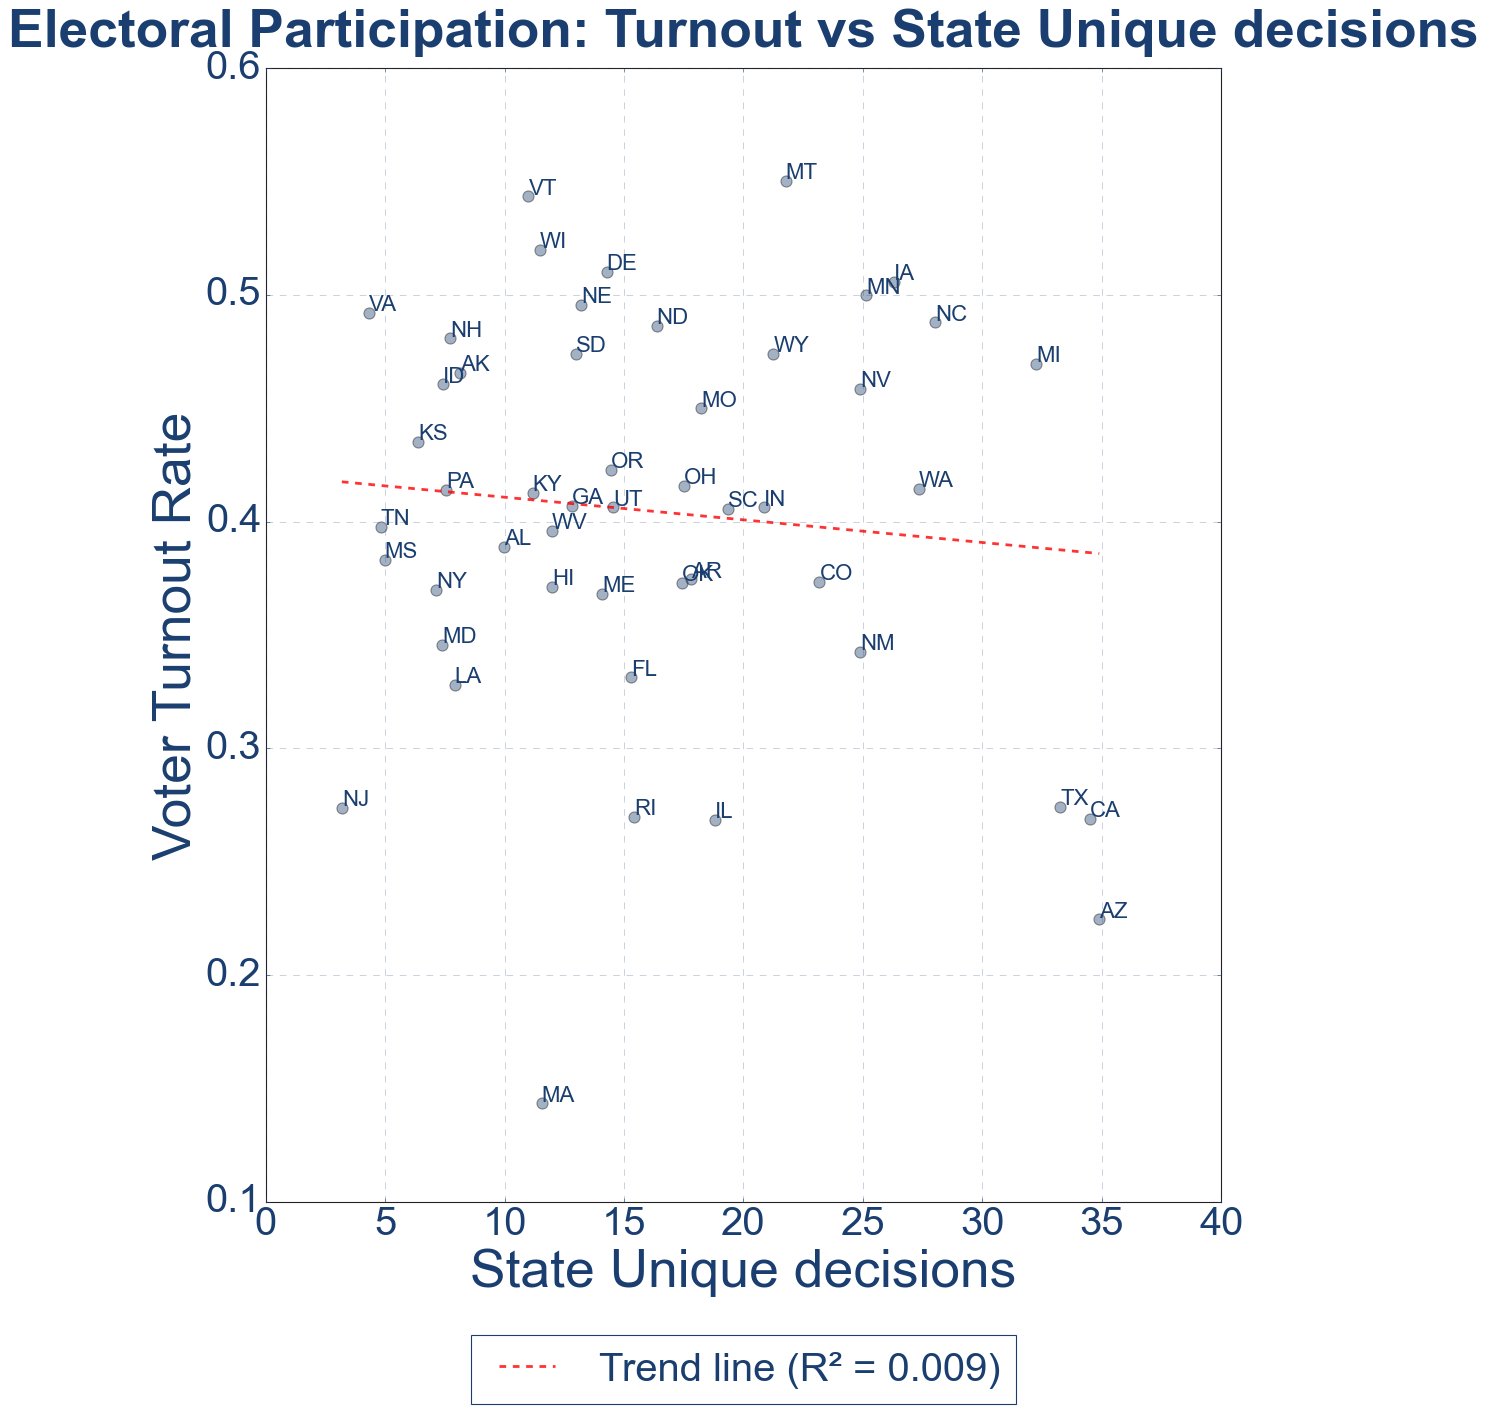

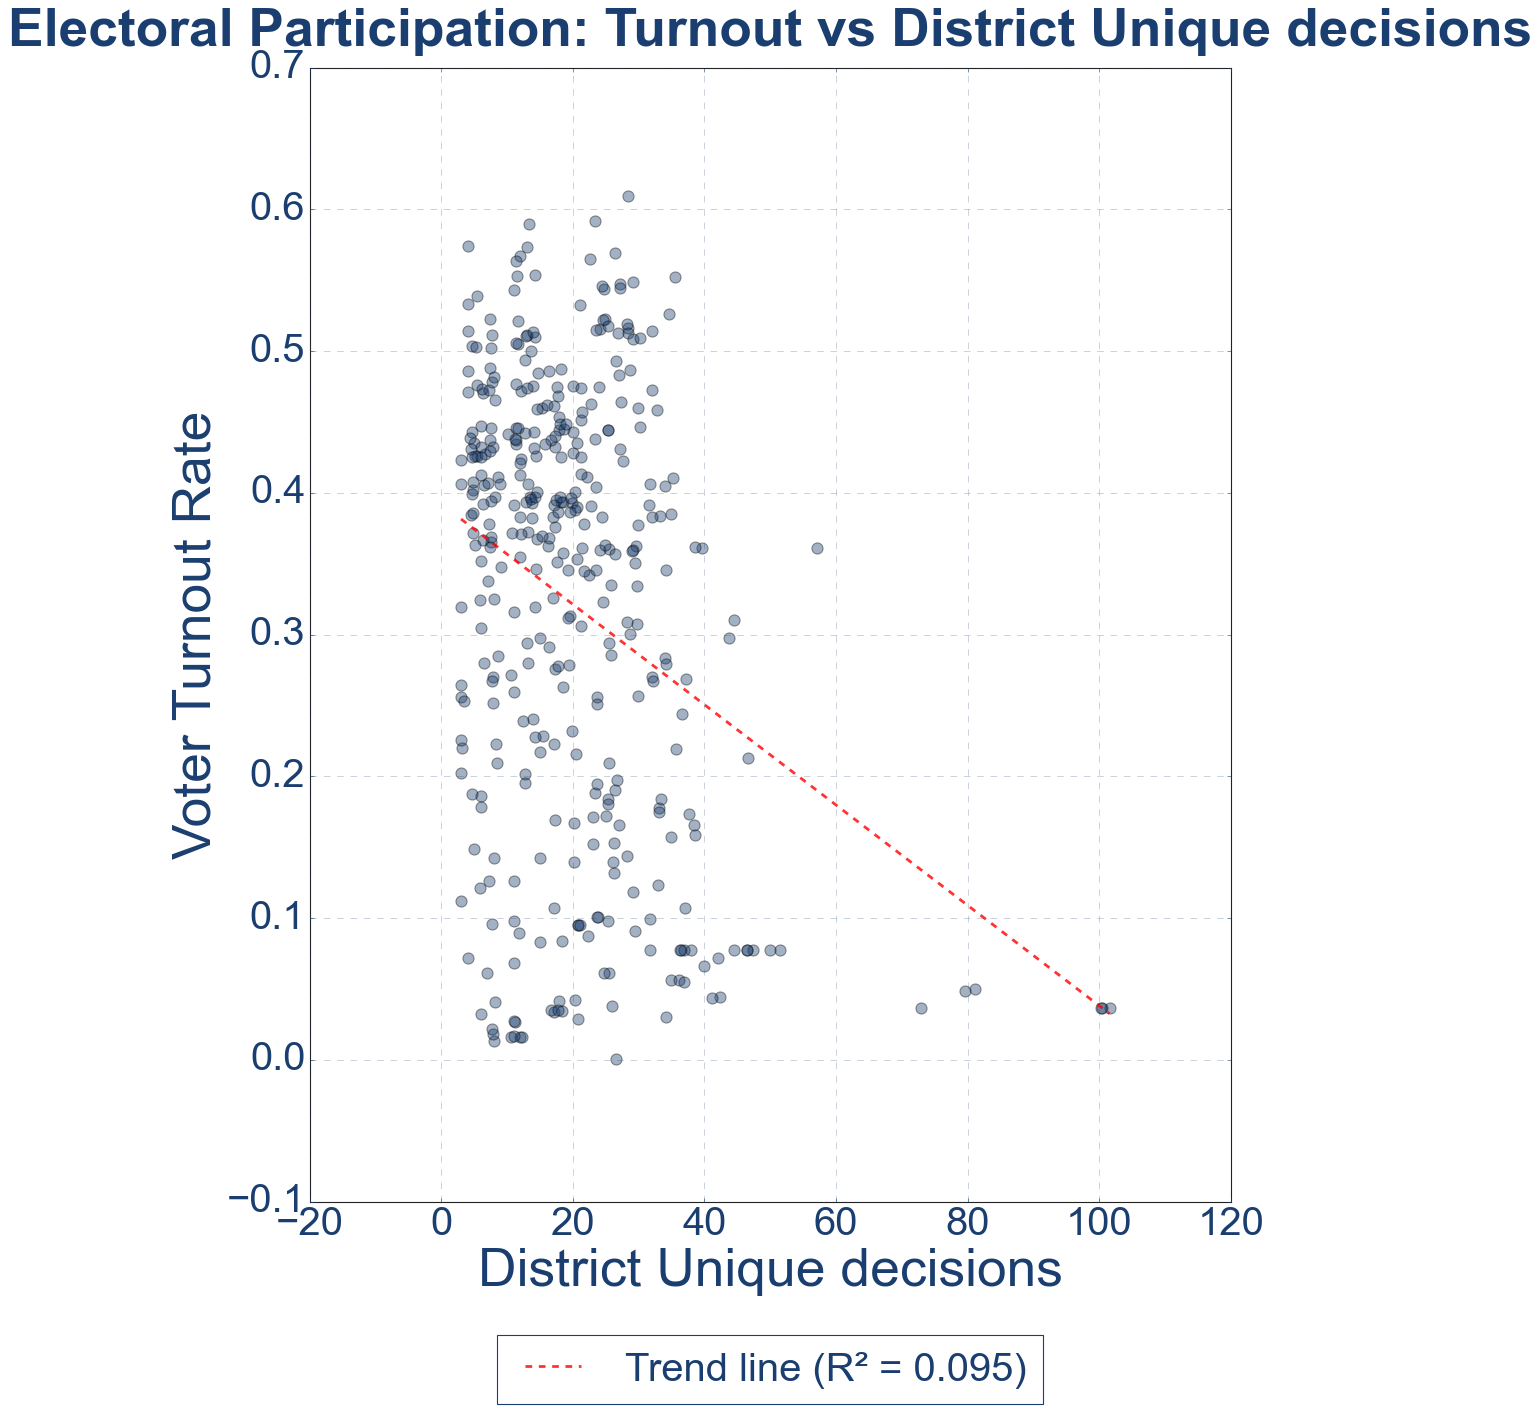

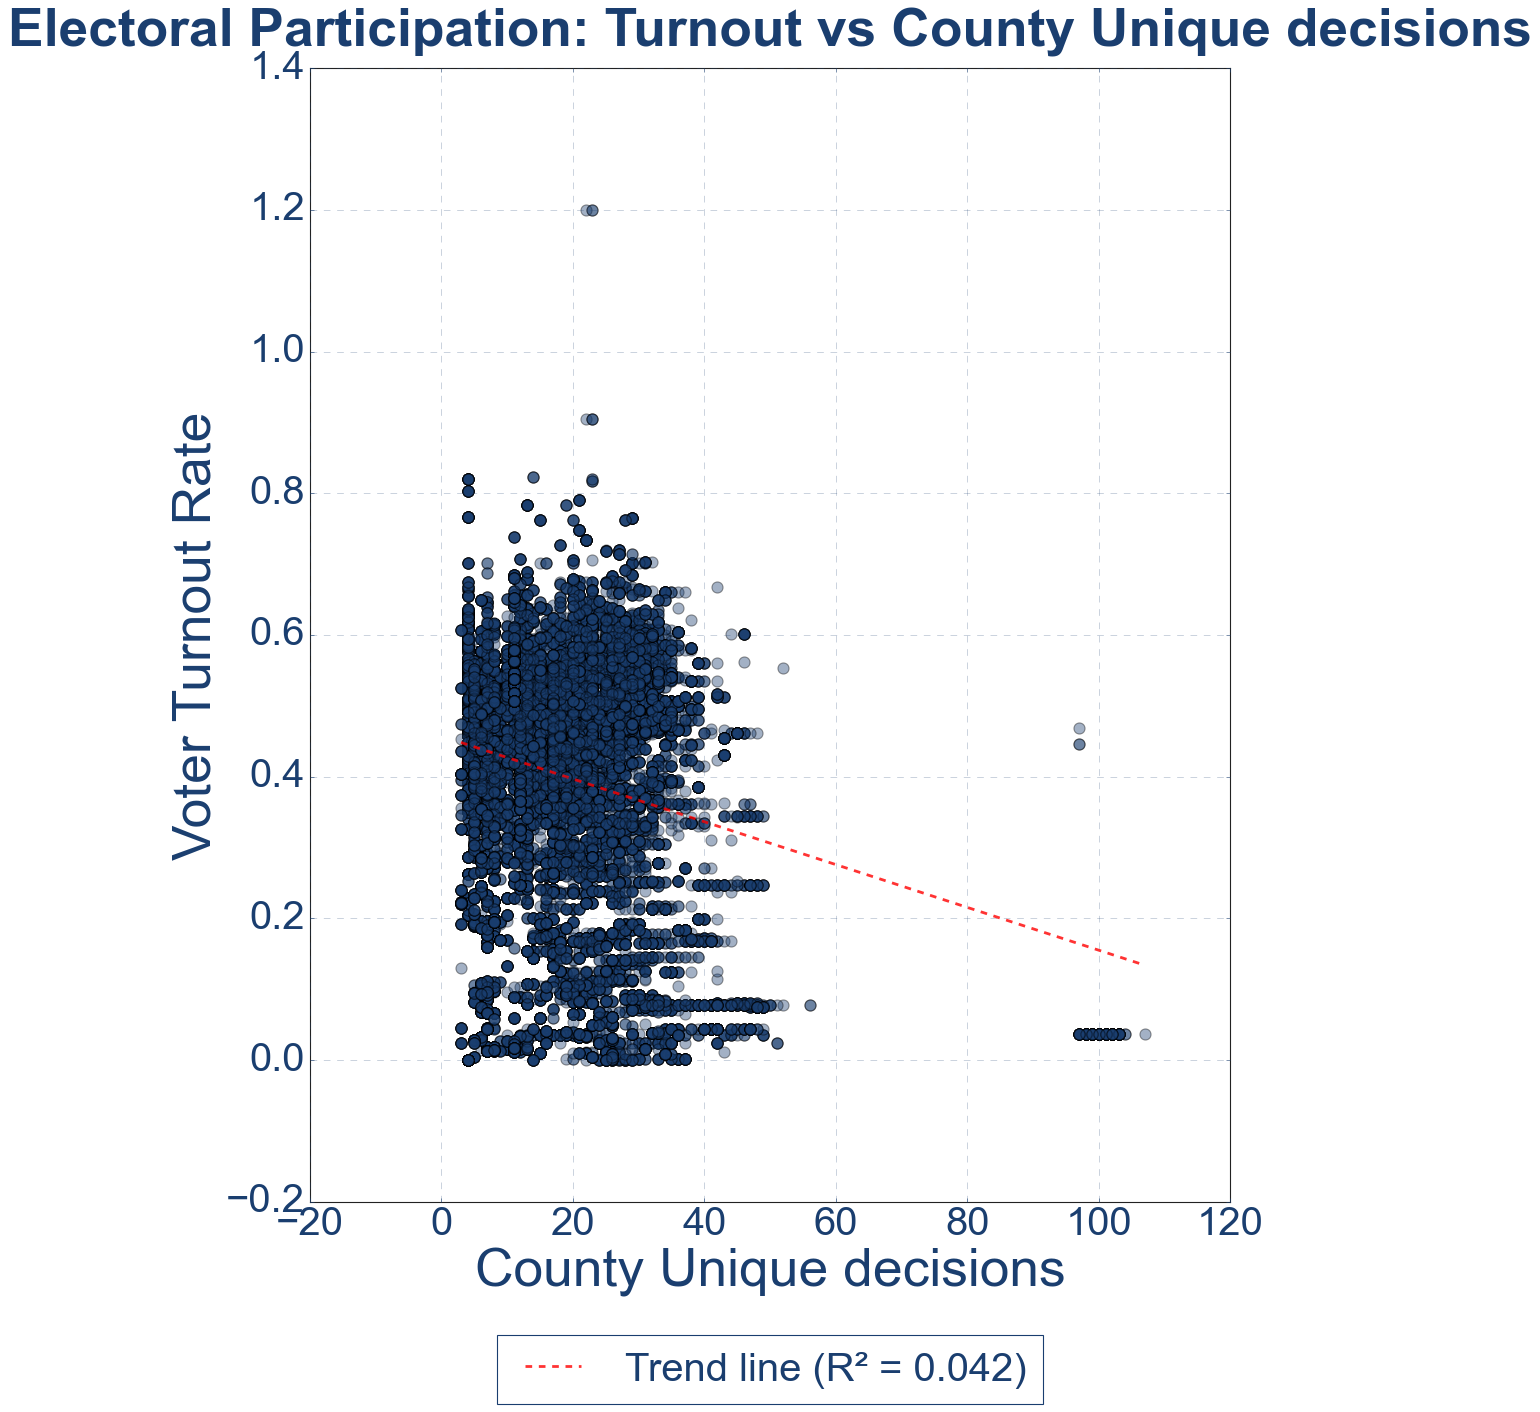

In [456]:
aggs = {'score': 'mean', 'turnout': 'mean', 'state_id': 'first', 'grade_level': 'mean',
        'unique_decisions': 'mean'}
trend_plot = create_trend_plot(map_df.groupby('State')[[
    'score', 'turnout', 'grade_level', 'state_id', 'unique_decisions'
]].agg(aggs), level='State', x_col='unique_decisions')
trend_plot.show()
trend_plot = create_trend_plot(map_df.groupby('district')[[
    'score', 'turnout', 'grade_level', 'state_id', 'unique_decisions'
]].agg(aggs), level='District', x_col='unique_decisions')
trend_plot.show()
trend_plot = create_trend_plot(map_df, x_col='unique_decisions')
trend_plot.show()

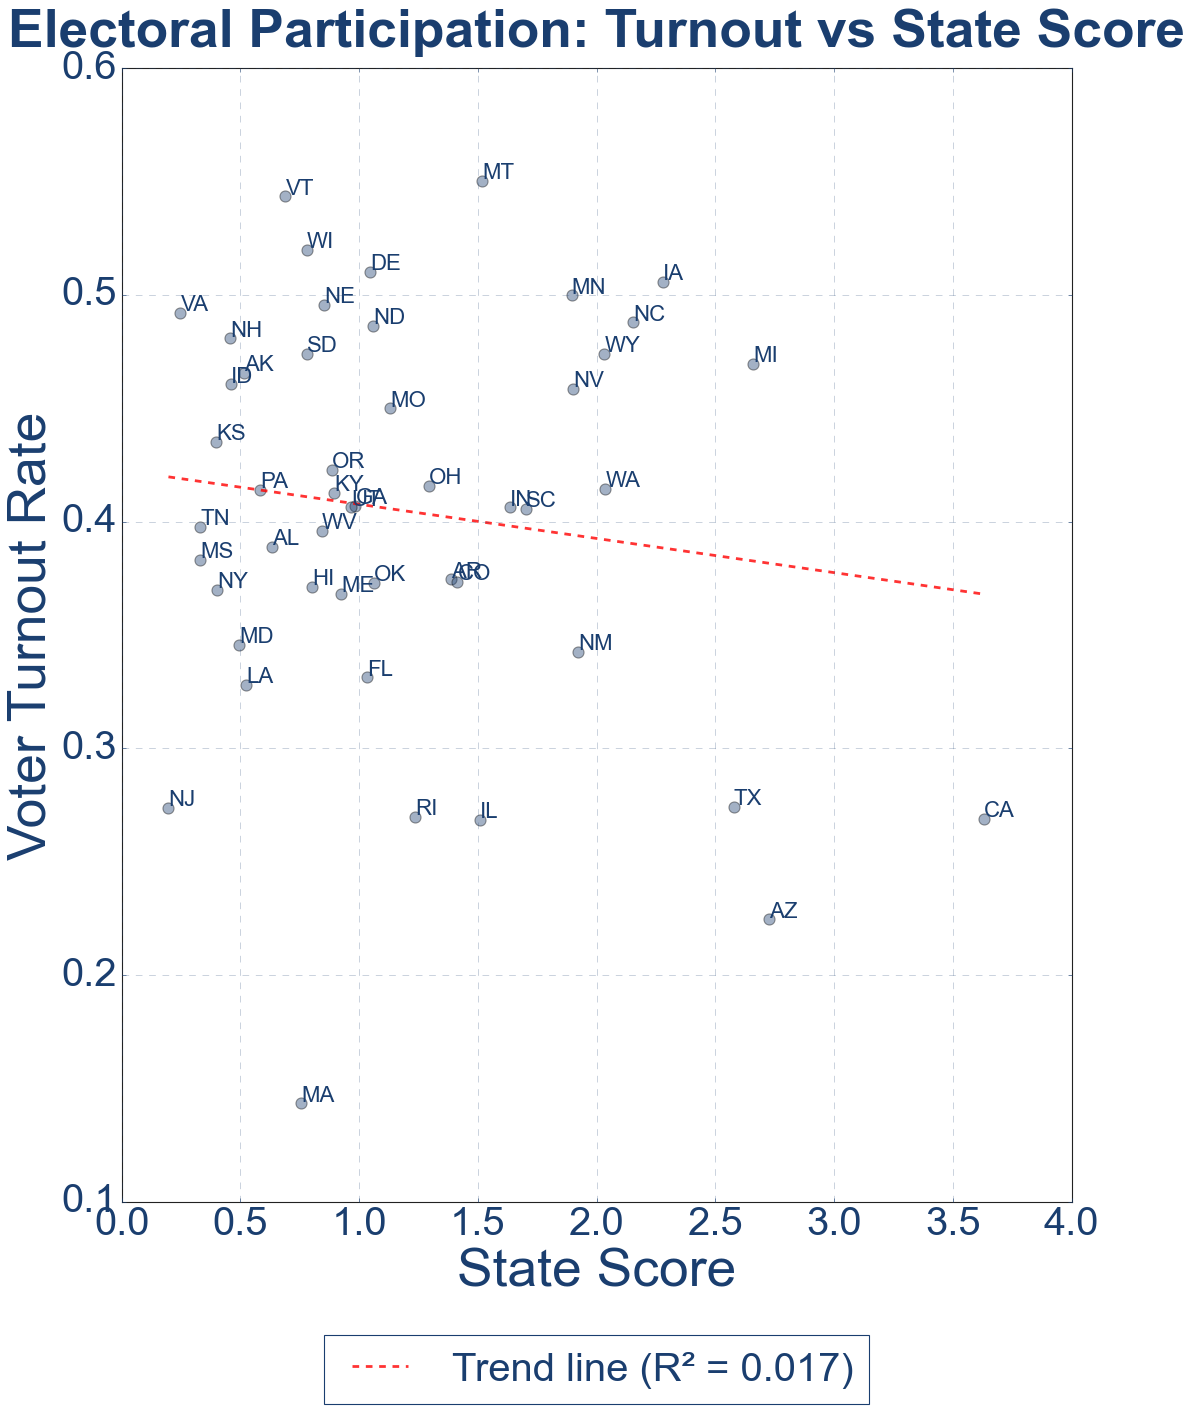

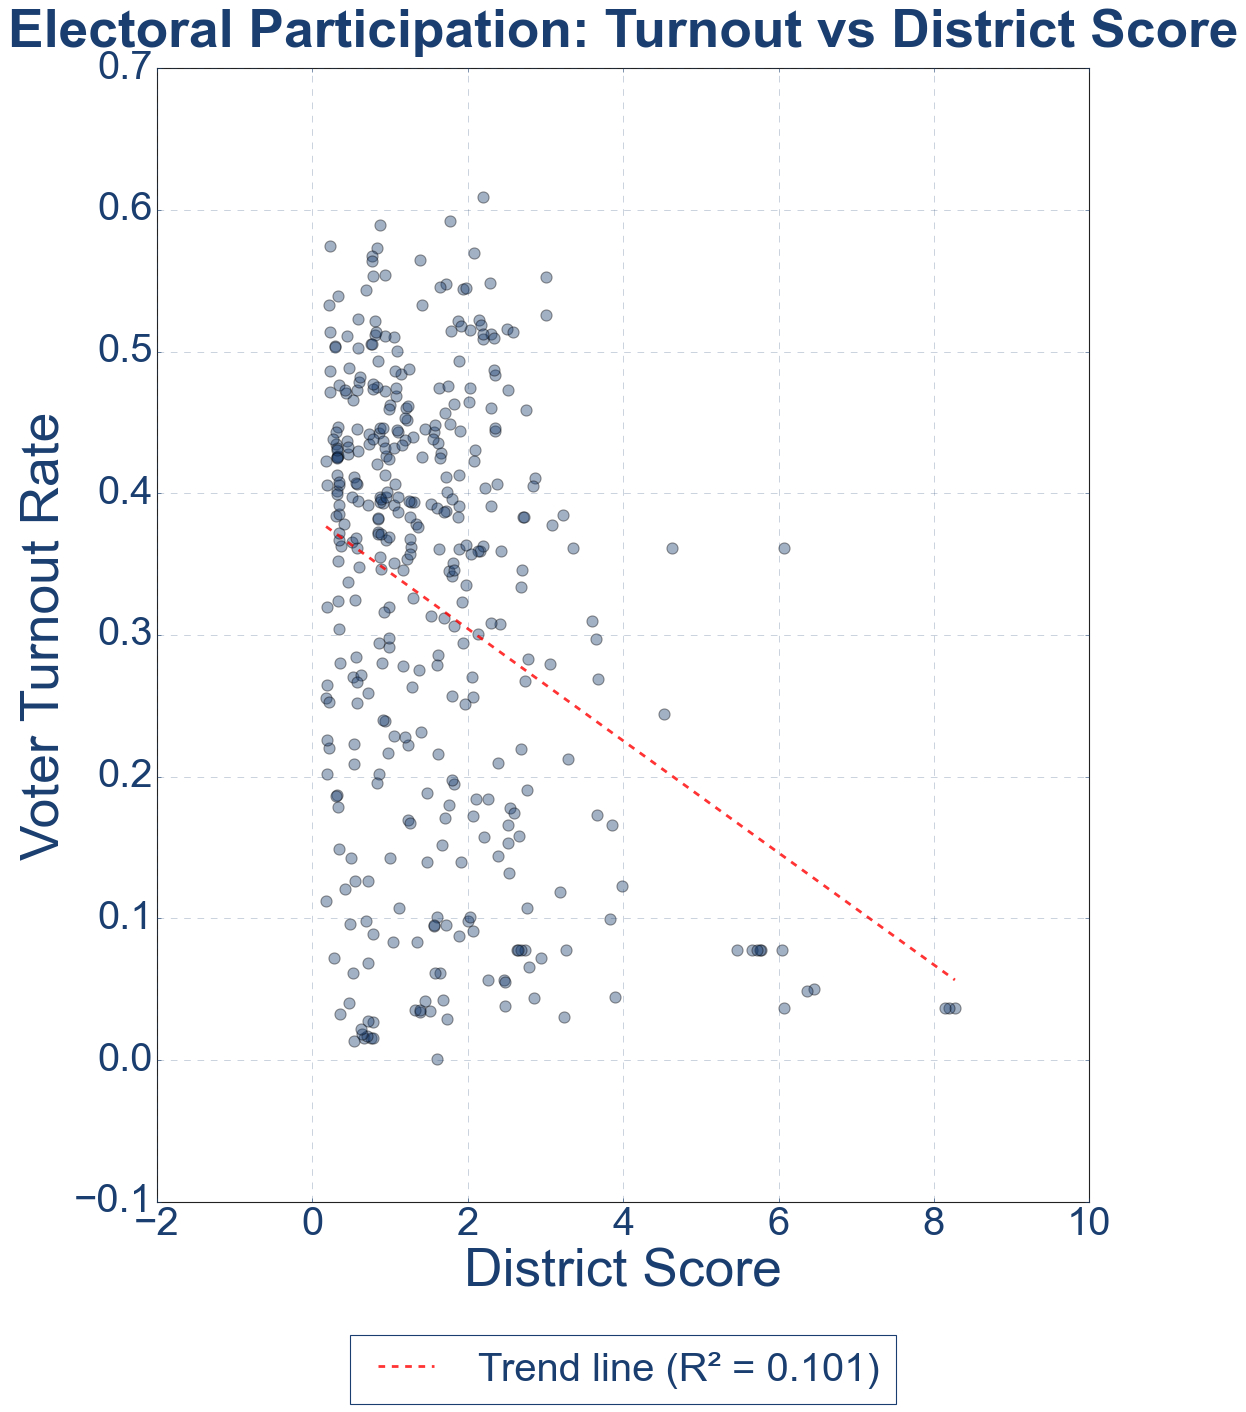

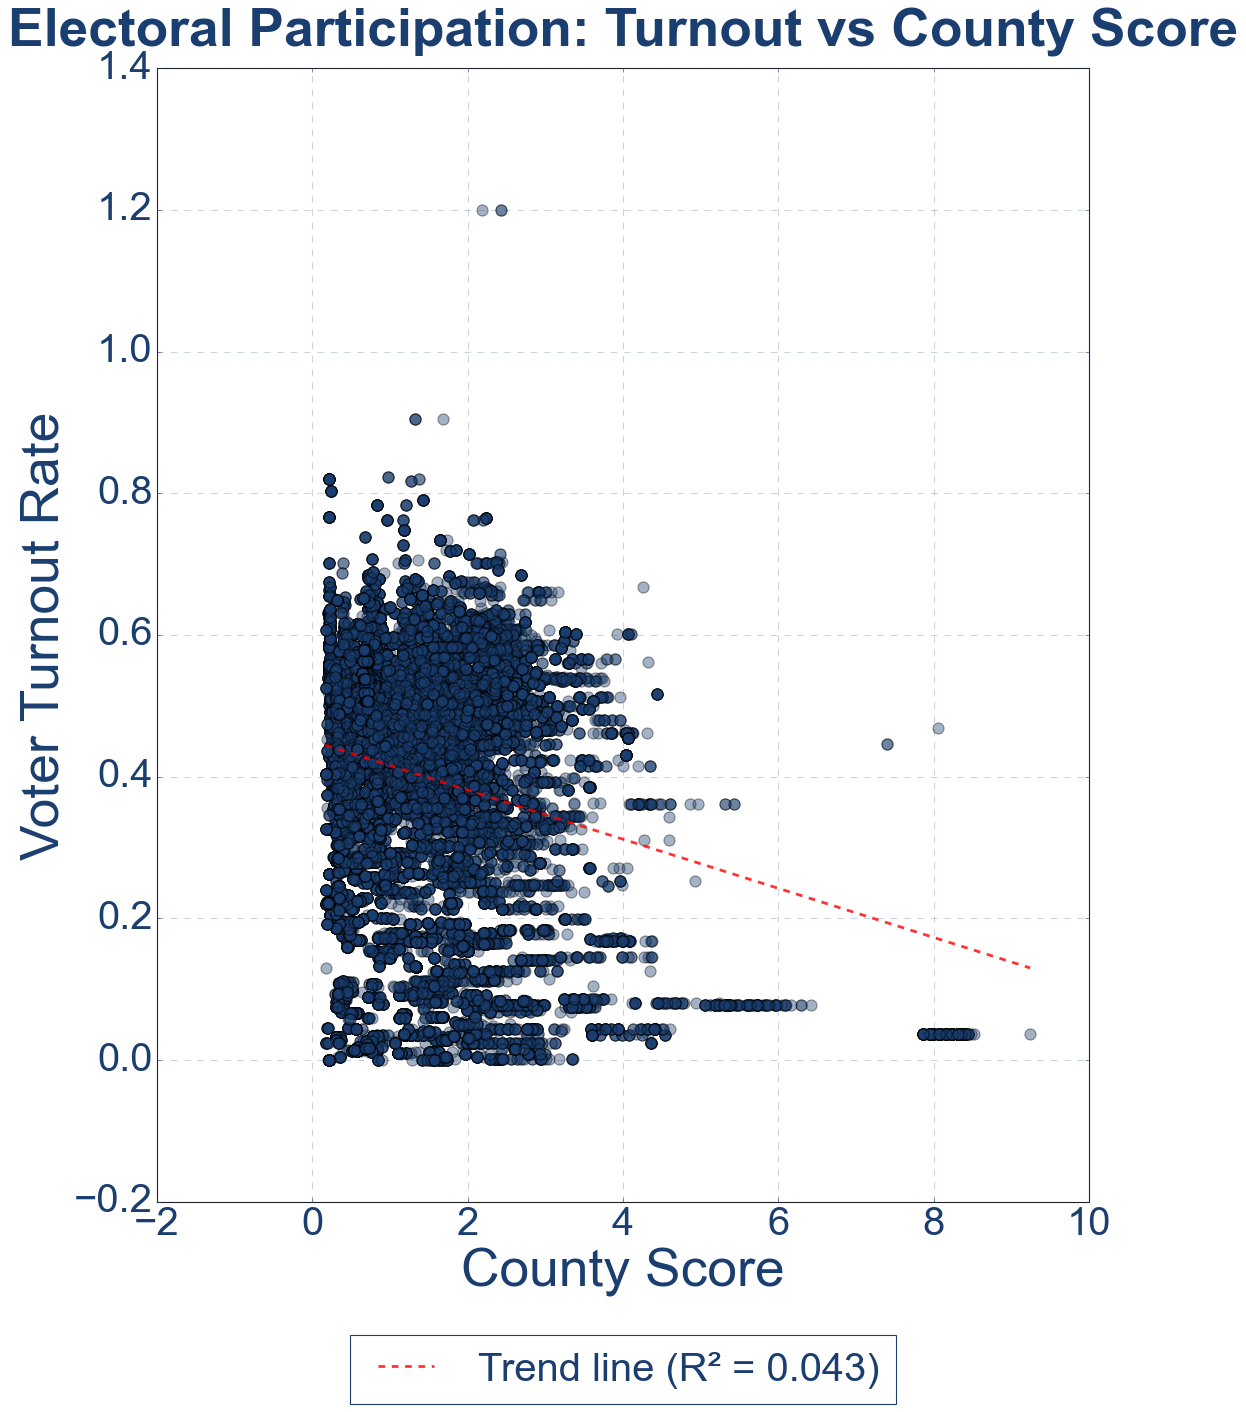

In [457]:
map_df = map_df[map_df.grade_level.notna()]
map_df['grade_level'] = map_df.grade_level.astype(float)
trend_plot = create_trend_plot(
    map_df.groupby('State')[['grade_level', 'turnout', 'score', 'state_id', 'unique_decisions']].agg(aggs),
    x_col='score', level='State'
)
trend_plot.show()
trend_plot = create_trend_plot(
    map_df.groupby('district')[['grade_level', 'turnout', 'score', 'state_id', 'unique_decisions']].agg(aggs),
    x_col='score', level='District'
)
trend_plot.show()
trend_plot = create_trend_plot(
    map_df,
    x_col='score'
)
trend_plot.show()

In [ ]:
alert("Created Trend Plots!")

In [461]:
map_df[map_df.State == 'Alaska'].turnout

3163     0.433044
3164     0.433044
3165     0.433044
3166     0.433044
3866     0.433044
           ...   
51778    0.433044
51779    0.433044
52544    0.433044
52545    0.433044
53216    0.433044
Name: turnout, Length: 257, dtype: float64

ak_mask.any()=True
hi_mask.any()=True


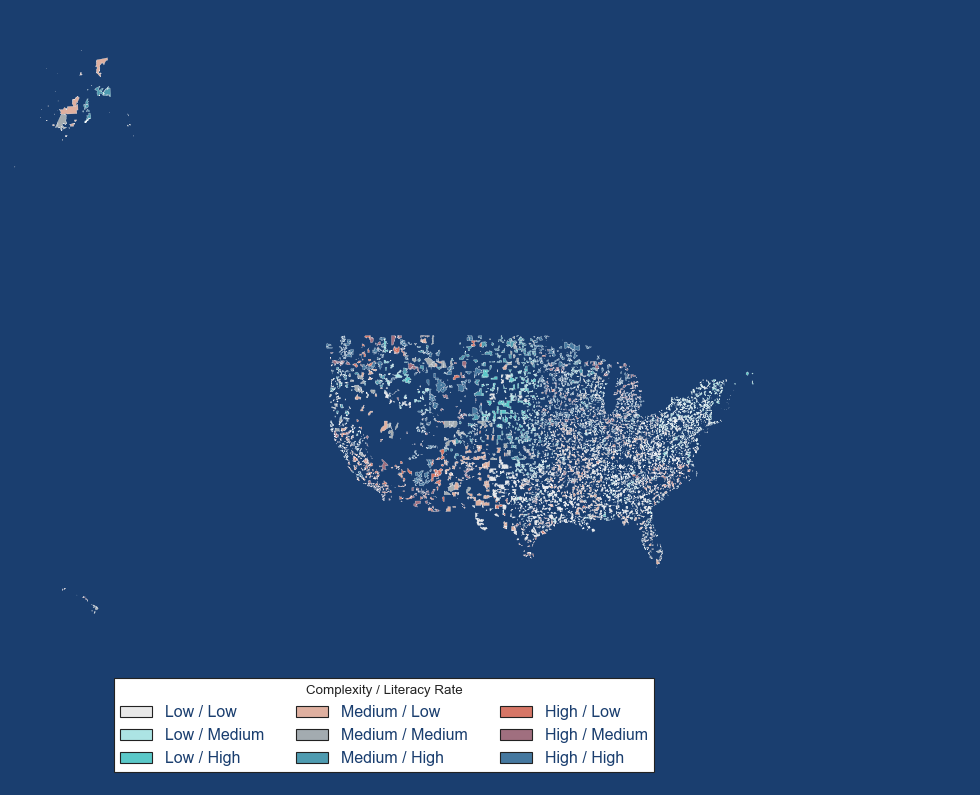

In [193]:
# Read your geodataframe here
# gdf = gpd.read_file('your_file.geojson')

# Create the map
fig, ax = create_bivariate_map_with_insets(map_df.sample(10000))

plt.show()

# Perform repairs

Fix old reports without having to reprocess all the data.

In [ ]:
data_df = pd.read_csv('data/processed/data_20241014.csv')

data_df['information_density'] = data_df.ballot_markdown.apply(
    lambda x: re.search(r'(Information Density\s+\|)\s(High|Medium|Low)', x)[2].lower()
)
data_df['word_count'] = data_df.ballot_markdown.apply(
    lambda x: int(re.search(r'(Word Count\s+\|)\s(\d+)', x)[2])
)
data_df['ballot_length'] = data_df.ballot_markdown.apply(
    lambda x: int(re.search(r'(Ballot Length\s+\|)\s(\d+)', x)[2])
)
data_df['information_density'] = data_df.ballot_markdown.apply(
    lambda x: re.search(r'(Information Density\s+\|)\s(High|Medium|Low)', x)[2].lower()
)
data_df['flesch_kincaid_grade'] = data_df.ballot_markdown.apply(
    lambda x: float((re.search(r'(Kincaid_Grade_Level\)\|)\s(\d+(\.\d+)?)', x) or [None] * 5)[2])
)
data_df['non_partisan_contests'] = data_df.ballot_markdown.apply(
    lambda x: bool(['No', 'Yes'].index((re.search(r'(Non-Partisan Contests Present\s+\|)\s(Yes|No)', x) or ['No'] * 3)[2]))
)

data_df['grade_level'] = data_df.flesch_kincaid_grade.apply(lambda x: f'{x:.1f}' if x <= 18 else '18+')
data_df['unique_decisions'] = data_df.ballot_markdown.str.count('---\n') - 1
data_df['unique_options'] = data_df.ballot_markdown.str.count('- \\[ \\]')
data_df['avg_options_per_decision'] = data_df['unique_options'] / data_df['unique_decisions']
data_df['avg_words_per_decision'] = data_df['word_count'] / data_df['unique_decisions']

In [406]:
def calculate_complexity_score(ballot_analysis, max_avg_options_per_decision, max_avg_words_per_decision, max_unique_decisions,
                               max_ballot_length, max_word_count, max_flesch_kincaid_grade):
    # Define weights for each indicator
    weights = {
        'ballot_length': 0.175,
        'word_count': 0.125,
        'avg_words_per_decision': 0.125,
        'unique_decisions': 0.15,
        'non_partisan_contests': 0.075,  # increased by 0.025
        'avg_options_per_decision': 0.125,
        'flesch_kincaid_grade': 0.125
    }
        
    # Extract values with nested field access where necessary
    score = (
        (ballot_analysis['ballot_length'] * weights['ballot_length'] / max_ballot_length) +
        (ballot_analysis['word_count'] * weights['word_count'] / max_word_count) +
        (ballot_analysis['avg_words_per_decision'] * weights['avg_words_per_decision'] / max_avg_words_per_decision) +
        (ballot_analysis['unique_decisions'] * weights['unique_decisions'] / max_unique_decisions) +
        (ballot_analysis['flesch_kincaid_grade'] * weights['flesch_kincaid_grade'] / max_flesch_kincaid_grade)
    )
    
    return score * 100
    
data_df['complexity_score'] = data_df.apply(
    calculate_complexity_score,
    max_ballot_length=data_df.ballot_length.max(),
    max_word_count=data_df.word_count.max(),
    max_avg_words_per_decision=data_df.avg_words_per_decision.max(),
    max_avg_options_per_decision=data_df.avg_options_per_decision.max(),
    max_unique_decisions=data_df.unique_decisions.max(),
    max_flesch_kincaid_grade=data_df.flesch_kincaid_grade.max(),
    axis=1
)

In [407]:
import re


def fix_row(row):
    text = row.ballot_markdown

    # Reformat numbers
    for metric, key, fmt in (
        ('Unique Decisions', 'unique_decisions', 'd'),
        ('Average Words per Decision', 'avg_words_per_decision', '.1f'),
        ('Average Options per Decision', 'avg_options_per_decision', '.1f'),
        ('Word Count', 'word_count', ','),
        ('Ballot Length', 'ballot_length', ','),
    ):
        text = re.sub(f'({metric}\\s*\\s?\\|)\\s(\\d+(\\.\\d+)?)', f'\\1 {getattr(row, key):{fmt}}', text)

    # Custom reformats
    text = re.sub(f'(Kincaid_Grade_Level\\)\\s*\\s?\\|)\\s(\\d+(\\.\\d+)?)', f'\\1 {row.grade_level:s} years of education', text)
    text = re.sub(f'(Overall Complexity Score: )(\\d+(\\.\\d+)?)', f'\\1 {row.complexity_score:.1f}', text)

    # Remove information density and non-partisan contests present
    text = re.sub(r'\|\s+\| Information Density\s+\|.*\|', '', text).replace('|\n\n|', '|\n|')
    text = re.sub(r'\|\s+\| Non-Partisan Contests Present\s+\|.*\|', '', text).replace('|\n\n|', '|\n|')
    
    # Remove type
    text = re.sub(r'\*\*Type:\*\* .+', '', text).replace('\n\n\n', '\n\n')
    

    # Rename unique decisions
    text = text.replace('Unique Decisions', 'Number of Questions')
    text = text.replace('Average Words per Decision', 'Average Words per Question')
    text = text.replace('Average Options per Decision', 'Average Options per Question')
    text = text.replace('Non-Partisan Contest Examples', 'Non-Partisan Contests')
    
    
    return text

data_df['fixed_markdown'] = data_df.apply(fix_row, axis=1)
data_df[['fixed_markdown', 'ballot_markdown']].apply(lambda x: [len(y) for y in x], axis=1)

0       [12341, 12847]
1       [25600, 26840]
2       [13049, 13585]
3         [5249, 5703]
4       [25693, 26914]
             ...      
4915      [8191, 8894]
4916      [4433, 4785]
4917      [6378, 6957]
4918      [4531, 4856]
4919      [8327, 8840]
Length: 4920, dtype: object

In [408]:
x = data_df.sample(1)
print(x.fixed_markdown.sample(1).iloc[0][:2000])
print(x.ballot_markdown.sample(1).iloc[0][:2000])

# Ballot Complexity Report
 
*This report provides an AI-assisted analysis of ballot complexity. Please note that this is a supplementary analysis and not a substitute for official election information.*

**Overall Complexity Score:  31.5/100**
|                         |                                 |                                          |
|-------------------------|---------------------------------|------------------------------------------|
| **Decision Complexity** | Number of Questions                | 15      |
|                         | Average Words per Question      | 56.1|
|                         | Average Options per Question    | 2.5|
|                         | Non-Partisan Contests  | U.S. Senate Texas, Texas Railroad Commission |
| **Language Complexity** | [Flesch-Kincaid Grade Level](https://ballotpedia.org/Ballot_measure_readability_scores,_2024#Flesch-Kincaid_Grade_Level)| 15.4 years of education       |
| **Length**              | Ballot Length            

In [412]:
columns = pd.read_csv('data/processed/data_20241014.csv').columns
output_df = data_df.drop(columns='ballot_markdown').rename(columns={'fixed_markdown': 'ballot_markdown'})[columns]
print(output_df.ballot_markdown.sample(1).iloc[0])

# Ballot Complexity Report
 
*This report provides an AI-assisted analysis of ballot complexity. Please note that this is a supplementary analysis and not a substitute for official election information.*

**Overall Complexity Score:  32.9/100**
|                         |                                 |                                          |
|-------------------------|---------------------------------|------------------------------------------|
| **Decision Complexity** | Number of Questions                | 17      |
|                         | Average Words per Question      | 53.6|
|                         | Average Options per Question    | 2.3|
|                         | Non-Partisan Contests  | U.S. Senate Texas - Tracy Andrus (Independent), Analisa Roche (Independent), Texas Railroad Commission - Richard McKibbin (Independent) |
| **Language Complexity** | [Flesch-Kincaid Grade Level](https://ballotpedia.org/Ballot_measure_readability_scores,_2024#Flesch-Kincaid_Grade_Le

In [411]:
output_df.to_csv('data/processed/data_20241027.csv', index=False)

# Map Analysis

In [240]:
data_df[['county', 'district', 'state', 'complexity_score']].iloc[0]

county                   Cook
district               IL-CD5
state                Illinois
complexity_score    49.065499
Name: 0, dtype: object

In [291]:
complexity_df.district.iloc[0]

'IL-CD5'

In [361]:
tipping_point_df.state.unique()

array(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California',
       'Colorado', 'Connecticut', 'Delaware', 'District of Columbia',
       'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana',
       'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'ME-1', 'ME-2', 'Maine',
       'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
       'Mississippi', 'Missouri', 'Montana', 'NE-1', 'NE-2', 'NE-3',
       'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico',
       'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma',
       'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina',
       'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont',
       'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming'],
      dtype=object)

In [339]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

def prepare_state_complexity(complexity_df):
    # Convert state names to uppercase for consistent matching
    complexity_df['state'] = complexity_df['state'].str.upper()
    
    # Group by state and calculate weighted median
    def weighted_median(group):
        # Sort complexity scores and corresponding weights
        sorted_data = group.sort_values('complexity_score')
        weights = sorted_data['voters']
        
        # Calculate cumulative weights
        cumsum = weights.cumsum()
        # Find middle point of total weight
        median_weight = weights.sum() / 2
        
        # Find the complexity score where cumulative weight crosses the median
        return sorted_data['complexity_score'][cumsum >= median_weight].iloc[0]
    
    return (complexity_df.groupby('state')
            .apply(weighted_median)
            .reset_index()
            .rename(columns={0: 'complexity_score'}))
    
def prepare_tipping_points(tipping_point_df):
    """Prepare tipping point probabilities."""
    tipping_data = tipping_point_df[['state', 'tipping']].copy()
    tipping_data['state'] = tipping_data['state'].str.upper()
    return tipping_data

def merge_state_data(state_complexity, tipping_data):
    """Merge complexity and tipping point data."""
    return state_complexity.merge(tipping_data, on='state', how='outer')

def create_color_scale():
    """Create a custom colormap from green to yellow to red."""
    colors = ['#FF00FF', '#00FFFF', '#FF3366', '#4DFF4D', '#FFD700']  # Neon pink, cyan, red, green, gold
    return LinearSegmentedColormap.from_list('custom', colors)

def get_state_colors(merged_data, colormap):
    """Generate colors for each state based on complexity and tipping point."""
    def get_color(row):
        if pd.isna(row['complexity_normalized']):
            return (0.8, 0.8, 0.8)  # Grey for missing data
        
        # Get base color from complexity score
        base_color = colormap(row['complexity_normalized'])
        
        # Adjust saturation based on tipping point
        # Scale up the typically small tipping point values
        saturation = min(1.0, row['tipping'] * 20) if not pd.isna(row['tipping']) else 0.5
        
        # Mix with white based on saturation
        white = np.array([1, 1, 1])
        color = np.array(base_color[:3])
        return tuple(white * (1 - saturation) + color * saturation)

    # Normalize complexity scores
    complexity_min = merged_data['complexity_score'].min()
    complexity_max = merged_data['complexity_score'].max()
    merged_data['complexity_normalized'] = (
        (merged_data['complexity_score'] - complexity_min) / 
        (complexity_max - complexity_min)
    )
    
    return [get_color(row) for _, row in merged_data.iterrows()]

def setup_map_figure():
    """Create and setup the figure and axes for the map."""
    fig, ax = plt.subplots(figsize=(15, 10))
    ax.set_aspect('equal')
    ax.axis('off')
    return fig, ax

def add_colorbar(fig, ax, vmin, vmax):
    """Add a colorbar to the map."""
    cmap = create_color_scale()
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    cbar = fig.colorbar(sm, ax=ax, orientation='horizontal', pad=0.05)
    cbar.set_label('Complexity Score', labelpad=10)
    return cbar

In [340]:
population_lookup = dict(zip(
    df.zip, df.population
))
pair_population_lookup = {}
for zip_code, pairs in pair_lookup.items():
    population_lookup[zip_code] /= len(pairs)
    for p in pairs:
        pair_population_lookup[p] = pair_population_lookup.get(p, 0) + population_lookup[zip_code]

NameError: name 'df' is not defined

In [356]:
# Example usage:
complexity_df = data_df.copy()
complexity_df['voters'] = complexity_df.apply(lambda x: pair_population_lookup[x.district if str(x.district) != 'nan' else None, x.county], axis=1)

STATES = set(tipping_point_df.state.unique())
complexity_df['new_district'] = complexity_df.district.str.replace('CD', '')
complexity_df['state'] = complexity_df.apply(lambda x: x.state if x.new_district not in STATES else x.new_district, axis=1)

tipping_point_df = pd.read_excel('data/raw/State_Topline.xlsx').query('modeldate == "10/23/2024"')
states_gdf = gpd.read_file('data/raw/tl_2024_us_state/tl_2024_us_state.shp')

In [357]:
# Prepare data
state_complexity = prepare_state_complexity(complexity_df)
tipping_data = prepare_tipping_points(tipping_point_df)
merged_data = merge_state_data(state_complexity, tipping_data)

/var/folders/jq/t9yd781506l5nzb9j3y9rrtm0000gn/T/ipykernel_93731/1363867142.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(weighted_median)


In [359]:
# Setup map
states_gdf = states_gdf.to_crs("ESRI:102003")
states_gdf['NAME'] = states_gdf.NAME.str.upper()
states_gdf = states_gdf.merge(merged_data, left_on='NAME', right_on='state', how='right')

# Generate colors
colormap = create_color_scale()
colors = get_state_colors(states_gdf, colormap)

# Create visualization
fig, ax = setup_map_figure()
states_gdf.plot(ax=ax, color=colors, edgecolor='black', linewidth=0.5)

# Add title and colorbar
plt.title('State Complexity Scores and Tipping Point Probabilities\n' +
          'Color: Green (Less Complex) to Red (More Complex)\n' +
          'Shade: White (Low Tipping Point Prob) to Full Color (High Tipping Point Prob)\n' +
          'Grey: No Data',
          pad=20)

add_colorbar(fig, ax, 
            vmin=states_gdf['complexity_score'].min(),
            vmax=states_gdf['complexity_score'].max())

plt.tight_layout()

plt.show()

KeyError: 'complexity_score'